In [1]:
# !pip install pyarrow

In [2]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
import matplotlib.dates as mdates

from apafib import load_dormir
from scipy import stats
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy


import warnings
warnings.filterwarnings('ignore')

# Definiciones
RND = 16

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                
    else:
        mant = p / (10.0**exp)
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    
# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

init_time = time()

# Práctica de APA. Ajuste y conclusiones de los diferentes modelos probados.

## Introducción

Autores: Oriol Farrés y Marc Gil

Como ya hemos explicado antes, en este notebook ajustaremos diferentes modelos y compararemos a ver cuál tiene mejores resultados, razonando el porqué. Al tratarse de un problema de clasificación, usaremos los siguientes modelos:

* Modelos líneales/cuadráticos: 

1. Regresión logística
2. K Nearest Neighbors
3. SVM líneal

* Modelos no líneales

1. Random Forest
2. XGBoost
3. Neural Networks
4. Ensamble

---

### Sobre el critero seguido para la interpretación y elección de los modelos

Por tal de asegurarnos obtener los resultados más rigurosos posibles utilizaremos la validación cruzada. Concretamente, al tratarse de un problema de series temporales, utilizaremos **TimeSeriesSplit**. 

El conjunto de test solo será utilizado para ver como generalizan los modelos, y garantizar que no hay **overfitting**, el criterio principal para ver qué modelo es mejor, es la puntuación de validación cruzada con K folds. Solo se usará (como criterio de desempate) el error de test para evaluar qué modelo es mejor que otro en el caso de que tengan la misma puntuación de validación cruzada.

---

# Índice del Notebook

## Parte 1-Preparado

**Fase A: Obtención de los datos**

1. Preámbulo

**Fase B: Preprocesado de las variabless**

0. Declaraciones y definiciones útiles
1. Dividir dataset en X e y
2. Definir columnas y pipelines
3. Aplicar Pipelines

**Fase C: Reducción de la dimensionalidad**

1. Aplicar PCA
2. Aplicar t-SNE
3. Comentarios sobre la reducción de dimensionalidad


## Parte 2-Ajuste 

0. Definiciones 

**Fase A: Modelos líneales/cuadráticos**

1. Regresión logística
2. K Nearest Neighbors
3. SVM líneal

**Fase B: Modelos no líneales**

1. Random Forest
2. XGBoost
3. Neural Networks
4. Ensamble


## Parte 3-Comparación de los modelos 

## Parte 4-Conclusiones 

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 1-Preparado

# Fase A-Obtención de los datos

## A.1-Preámbulo

> Tenemos todo el dataset limpio preparado en el directorio data/clean/matches.parquet.

In [3]:
tennis_train = pd.read_parquet("data/clean/atp_matches_train.parquet")
tennis_test = pd.read_parquet("data/clean/atp_matches_test.parquet")

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B-Preprocesado de las variables

**Nota:** Utilizaremos pipelines para asegurarnos de la robustez del preprocesado de las variables.

## B.0-Declaraciones y definiciones útiles

Antes de empezar, vamos a hacer definiciones para facilitar el código en todo el notebook.

In [4]:
# Definimos target
target = 'Winner'

features = tennis_train.columns.drop(target).tolist()
numerical_features = tennis_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = tennis_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar el target de las númericas (está codificada ya como 0/1)
numerical_features.remove(target)

print("--- Clasificación de Variables ---")
print(f"Target: {target}")
print(f"Numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Categóricas ({len(categorical_features)}): {categorical_features}")

--- Clasificación de Variables ---
Target: Winner
Numéricas (42): ['draw_size', 'best_of', 'tourney_points', 'diff_elo_blend', 'diff_days_since', 'diff_injury', 'diff_seed', 'diff_ht', 'diff_age', 'diff_rank', 'diff_rank_points', 'diff_h2h', 'diff_is_seeded', 'diff_is_first_match', 'diff_df_pct_last_1', 'diff_win_rate_last_1', 'diff_df_pct_last_10', 'diff_tb_rate_last_1', 'diff_win_rate_last_10', 'diff_tb_won_pct_last_5', 'diff_df_pct_last_5', 'diff_win_rate_lifetime', 'diff_win_rate_last_5', 'diff_tb_won_pct_last_10', 'diff_bp_save_pct_last_1', 'diff_1st_won_pct_last_5', 'diff_1st_won_pct_lifetime', 'diff_bp_save_pct_last_5', 'diff_bp_save_pct_lifetime', 'diff_ace_pct_last_5', 'diff_tb_rate_last_10', 'diff_ace_pct_last_1', 'diff_tb_rate_lifetime', 'diff_is_rookie', 'diff_tb_rate_last_5', 'diff_ace_pct_last_10', 'diff_tb_won_pct_last_1', 'diff_bp_save_pct_last_10', 'diff_1st_won_pct_last_1', 'diff_1st_won_pct_last_10', 'diff_elo', 'diff_elo_surface']
Categóricas (6): ['surface', 'tourn

---

## B.1-Dividir dataset en X e y


In [5]:

X_train = tennis_train.drop(columns=[target])
y_train = tennis_train[target]

X_test = tennis_test.drop(columns=[target])
y_test = tennis_test[target]

---

## B.2-Definir columnas y pipelines

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config

set_config(transform_output="pandas")

# Variables Numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Variables Categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Variables Ordinales
#ord_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('encoder', OrdinalEncoder(categories=[bmi_order])) 
#])

---

## B.3-Aplicar Pipelines

In [7]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features),
    #('ord', ord_pipeline, ordinal_features)
], verbose_feature_names_out=False)

Aunque no vamos a usar X_processed, ya que los modelos usarán cada uno la pipeline directamente, definimos X_processed para el PCA y t-SNE que si lo necesitan (y para verificar que no peta nada).

In [8]:
print("\n--- Verificación del Preprocesador (Primeras 3 filas transformadas) ---")
X_train_processed = preprocessor.fit_transform(X_train)
display(X_train_processed.head(3))

# Aprovechamos para definir la constante
FEATURE_NAMES = X_train_processed.columns.tolist()


--- Verificación del Preprocesador (Primeras 3 filas transformadas) ---


draw_size   best_of  tourney_points  diff_elo_blend  diff_days_since  \
0   1.722584  1.982285        1.850274        0.245639         0.011717   
1  -0.665468 -0.504468       -0.800901        0.396306        -1.892586   
2   1.722584 -0.504468        0.335317       -0.466828         0.002100   

   diff_injury  diff_seed   diff_ht  diff_age  diff_rank  ...  p1_entry_SE  \
0     0.095430  -0.011298  0.496184 -0.842070  -0.225087  ...          0.0   
1    -3.547269  -0.011298  0.000099  0.686485  -0.085928  ...          0.0   
2     0.095430  -0.011298 -2.281892 -0.373081   0.147257  ...          0.0   

   p1_entry_WC  p1_hand_R  p2_entry_DA  p2_entry_LL  p2_entry_PR  p2_entry_Q  \
0          0.0        1.0          1.0          0.0          0.0         0.0   
1          0.0        1.0          0.0          1.0          0.0         0.0   
2          0.0        1.0          1.0          0.0          0.0         0.0   

   p2_entry_SE  p2_entry_WC  p2_hand_R  
0          0.0          0.0        1.0  
1          0.0          0.0        0.0  
2          0.0          0.0        1.0  

[3 rows x 63 columns]

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase C-Reducción de la dimensionalidad

**Fase C: Reducción de la dimensionalidad**

1. Aplicar PCA
2. Aplicar t-SNE
3. Comentarios sobre la reducción de dimensionalidad

## C.1-Aplicar PCA

In [9]:
from sklearn.decomposition import PCA

myPCA = PCA().fit(X_train_processed)
print(myPCA.explained_variance_ratio_.cumsum())

[0.19830929 0.31751353 0.3833527  0.44125368 0.49483443 0.54097136
 0.58212885 0.61897052 0.64920035 0.67603287 0.70125509 0.72462014
 0.74710719 0.76735552 0.78566008 0.80178647 0.81696994 0.8311307
 0.84485957 0.85734285 0.86944879 0.88004354 0.89043473 0.90042038
 0.90993897 0.91814791 0.92623418 0.93364315 0.94053263 0.94720748
 0.95223166 0.95724426 0.9619293  0.96628742 0.97008721 0.97341097
 0.97671658 0.97994139 0.9827379  0.98539886 0.98791088 0.98975224
 0.99140958 0.99301775 0.99459573 0.9960573  0.99746407 0.99823106
 0.99871019 0.99914338 0.99944193 0.99958824 0.99973038 0.9998637
 0.99991548 0.99996217 0.99999276 0.99999816 0.99999938 1.
 1.         1.         1.        ]


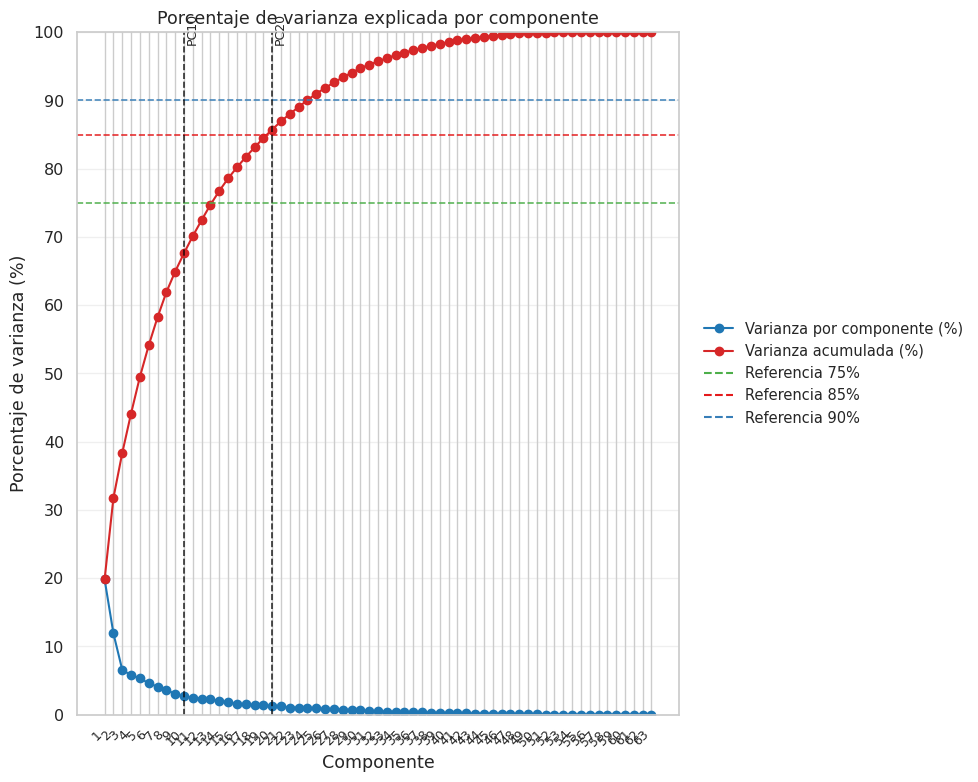

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

evr = myPCA.explained_variance_ratio_
cum_evr = evr.cumsum()
evr_pct = evr * 100
cum_pct = cum_evr * 100
m = len(evr_pct)
x = np.arange(1, m + 1)

line1, = ax.plot(x, evr_pct, marker='o', color='#1f77b4', label='Varianza por componente (%)', linewidth=1.5)
line2, = ax.plot(x, cum_pct, marker='o', color='#d62728', label='Varianza acumulada (%)', linewidth=1.5)

ref_levels = [75, 85, 90]
ref_colors = ['#4daf4a', '#e41a1c', '#377eb8']
for lvl, col in zip(ref_levels, ref_colors):
    ax.axhline(lvl, color=col, linestyle='--', linewidth=1.2, alpha=0.9)

# líneas verticales en PC10 y PC20 (si existen)
if m >= 10:
    ax.axvline(10, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    ax.text(10 + 0.2, ax.get_ylim()[1]*0.98, 'PC10', rotation=90, va='top', ha='left', fontsize=9)
if m >= 20:
    ax.axvline(20, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    ax.text(20 + 0.2, ax.get_ylim()[1]*0.98, 'PC20', rotation=90, va='top', ha='left', fontsize=9)

ax.set_xlabel('Componente')
ax.set_ylabel('Porcentaje de varianza (%)')
ax.set_title('Porcentaje de varianza explicada por componente')

ax.set_xticks(x)
if m > 10:
    ax.set_xticklabels(x, rotation=45, ha='right', fontsize=9)
else:
    ax.set_xticklabels(x)

ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(axis='y', alpha=0.3)

from matplotlib.lines import Line2D
data_handles, data_labels = ax.get_legend_handles_labels()
ref_handles = [Line2D([0], [0], color=c, lw=1.5, linestyle='--') for c in ref_colors]
ref_labels = [f'Referencia {int(l)}%' for l in ref_levels]
ax.legend(data_handles + ref_handles, data_labels + ref_labels,
          loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=False)

plt.tight_layout()
plt.show()

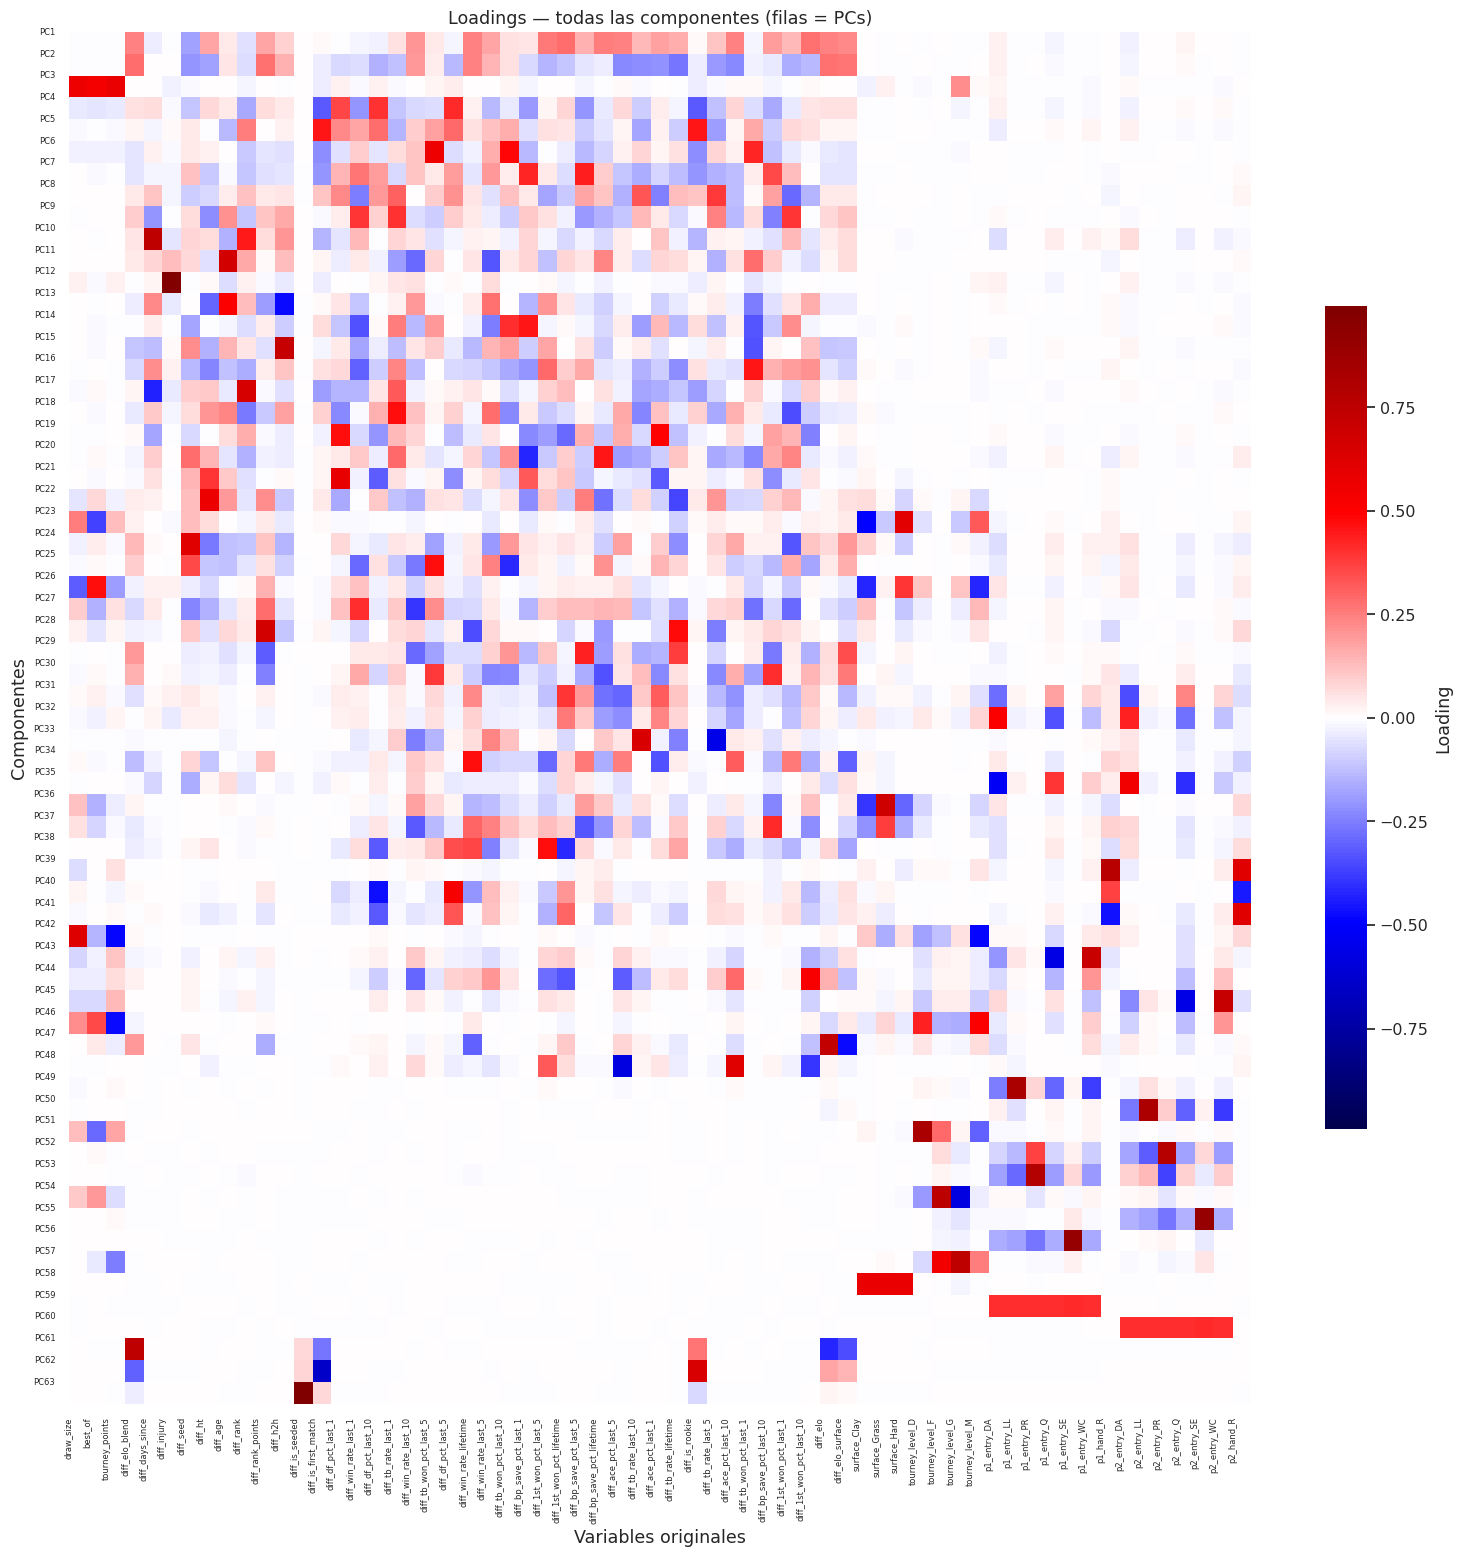

In [11]:
components = myPCA.components_ 
pc_labels = [f'PC{i+1}' for i in range(components.shape[0])]
comp_df = pd.DataFrame(components, index=pc_labels, columns=FEATURE_NAMES)

n_rows, n_cols = comp_df.shape
fig_w = max(12, n_cols * 0.25)
fig_h = max(6, n_rows * 0.25)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

v = np.max(np.abs(comp_df.values))
sns.heatmap(
    comp_df,cmap='seismic',center=0,annot=False,fmt=".3f",
    vmin=-v,vmax=v,cbar_kws={'label': 'Loading', 'shrink': 0.6},ax=ax
)

ax.set_title('Loadings — todas las componentes (filas = PCs)')
ax.set_xlabel('Variables originales')
ax.set_ylabel('Componentes')

ax.set_xticks(np.arange(n_cols))
if n_cols > 30:
    ax.set_xticklabels(comp_df.columns, rotation=90, fontsize=6)
else:
    ax.set_xticklabels(comp_df.columns, rotation=45, ha='right', fontsize=8)

ax.set_yticks(np.arange(n_rows))
ax.set_yticklabels(comp_df.index, rotation=0, fontsize=max(6, min(9, 200//n_rows)))

plt.tight_layout()
plt.show()

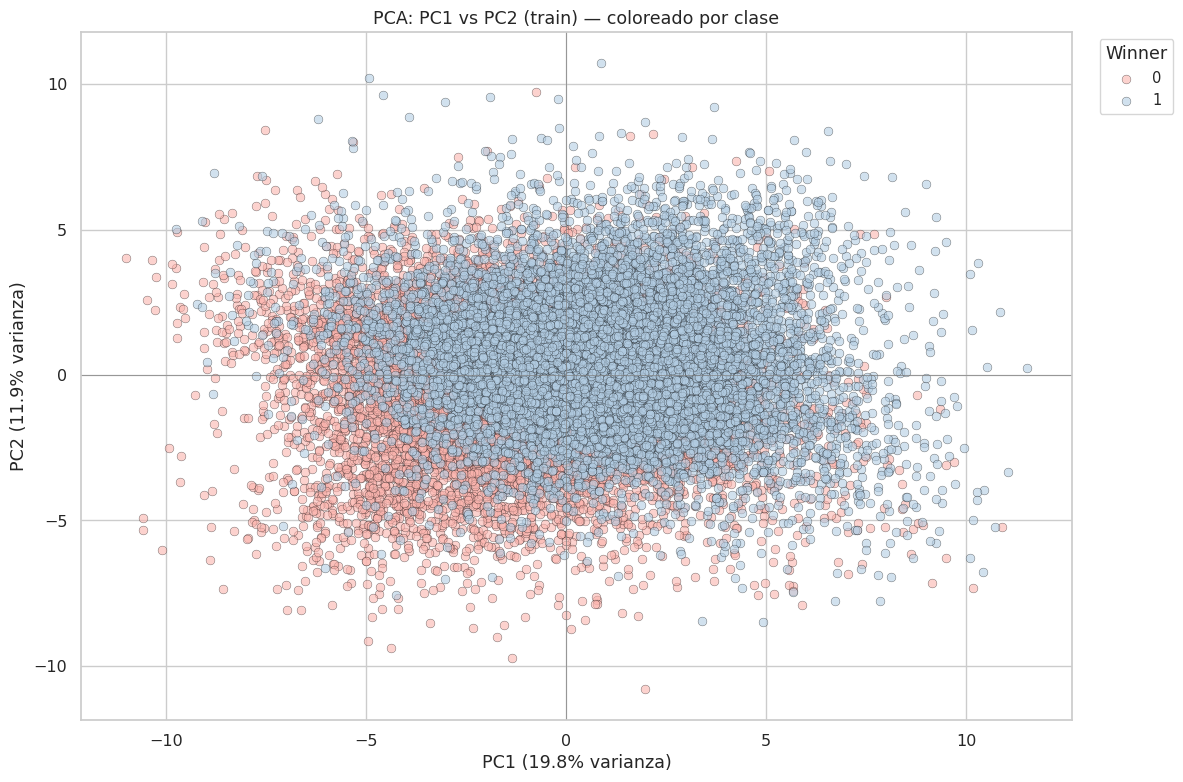

In [12]:
pca_result = myPCA.transform(X_train_processed)
pca_result = np.asarray(pca_result)  # garantizar array numpy

expl_var = myPCA.explained_variance_ratio_ * 100

unique_classes = np.unique(y_train)
palette = sns.color_palette("Pastel1", n_colors=len(unique_classes))
plt.figure(figsize=(12, 8))
ax = plt.gca()

for i, cls in enumerate(unique_classes):
    mask = (y_train.values == cls)
    ax.scatter(
        pca_result[mask, 0],
        pca_result[mask, 1],
        label=cls,
        s=40,
        alpha=0.6,
        edgecolor='black',
        linewidth=0.3,
        color=palette[i % len(palette)]
    )

ax.set_xlabel(f'PC1 ({expl_var[0]:.1f}% varianza)')
ax.set_ylabel(f'PC2 ({expl_var[1]:.1f}% varianza)')
ax.axhline(0, color='grey', linewidth=0.5)
ax.axvline(0, color='grey', linewidth=0.5)
ax.set_title('PCA: PC1 vs PC2 (train) — coloreado por clase')

ax.legend(title=target, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

--- 
## C.2-Aplicar t-SNE

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=RND,
    perplexity=30.0,
    learning_rate='auto', 
    n_jobs=-1,            # Paralelizar  
    max_iter=1000,
    verbose=1
)

print("Iniciando ajuste de t-SNE (sobre datos estandarizados)...")

X_train_tsne = tsne.fit_transform(X_train_processed)

Iniciando ajuste de t-SNE (sobre datos estandarizados)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25155 samples in 0.013s...
[t-SNE] Computed neighbors for 25155 samples in 0.887s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25155
[t-SNE] Computed conditional probabilities for sample 2000 / 25155
[t-SNE] Computed conditional probabilities for sample 3000 / 25155
[t-SNE] Computed conditional probabilities for sample 4000 / 25155
[t-SNE] Computed conditional probabilities for sample 5000 / 25155
[t-SNE] Computed conditional probabilities for sample 6000 / 25155
[t-SNE] Computed conditional probabilities for sample 7000 / 25155
[t-SNE] Computed conditional probabilities for sample 8000 / 25155
[t-SNE] Computed conditional probabilities for sample 9000 / 25155
[t-SNE] Computed conditional probabilities for sample 10000 / 25155
[t-SNE] Computed conditional probabilities for sample 11000 / 25155
[t-SNE] Computed conditional probabilities for sample 12000 

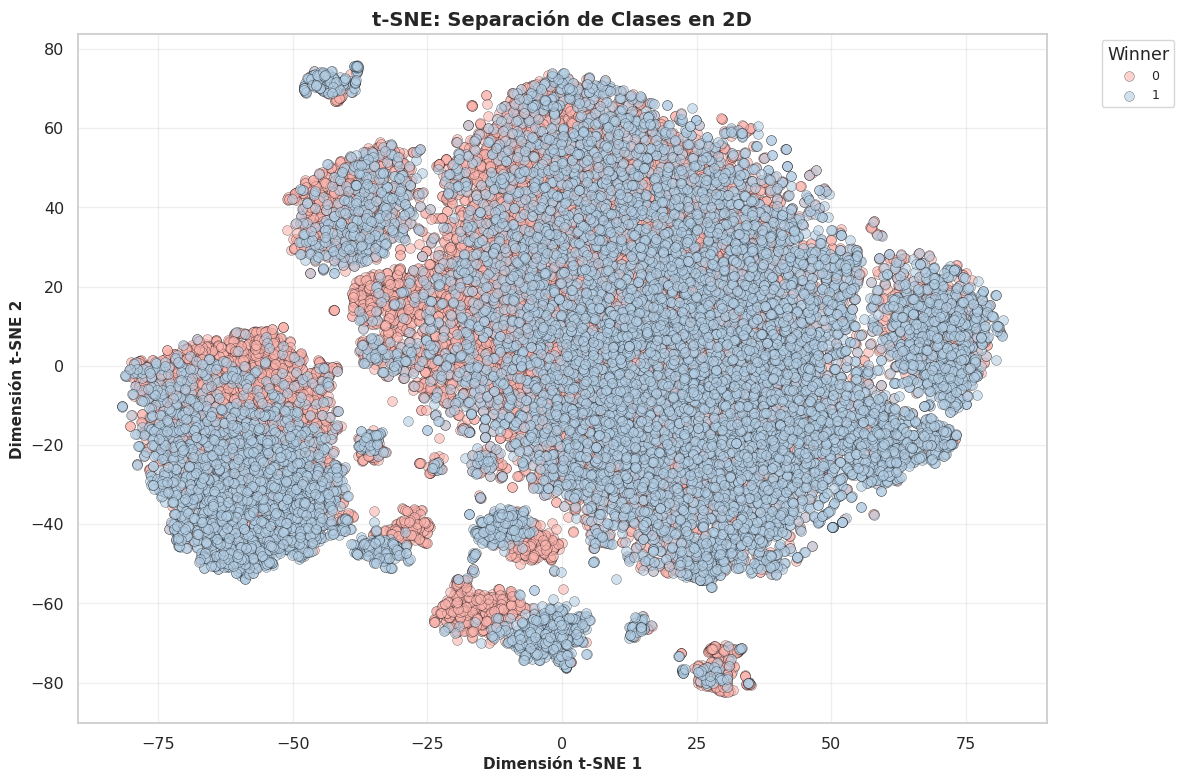

In [14]:
# Visualización en 2D con t-SNE (corregido)
X_train_tsne = np.asarray(X_train_tsne)
unique_classes = np.unique(y_train)
palette = sns.color_palette("Pastel1", n_colors=len(unique_classes))

plt.figure(figsize=(12, 8))
for i, cls in enumerate(unique_classes):
    mask = (y_train.values == cls)        # usar .values para obtener boolean ndarray
    plt.scatter(
        X_train_tsne[mask, 0],
        X_train_tsne[mask, 1],
        label=cls,
        alpha=0.6,
        s=50,
        color=palette[i % len(palette)],
        edgecolors='black',
        linewidth=0.3
    )

plt.xlabel('Dimensión t-SNE 1', fontsize=11, fontweight='bold')
plt.ylabel('Dimensión t-SNE 2', fontsize=11, fontweight='bold')
plt.title('t-SNE: Separación de Clases en 2D', fontsize=14, fontweight='bold')
plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## C.3-Comentarios sobre la reducción de dimensionalidad

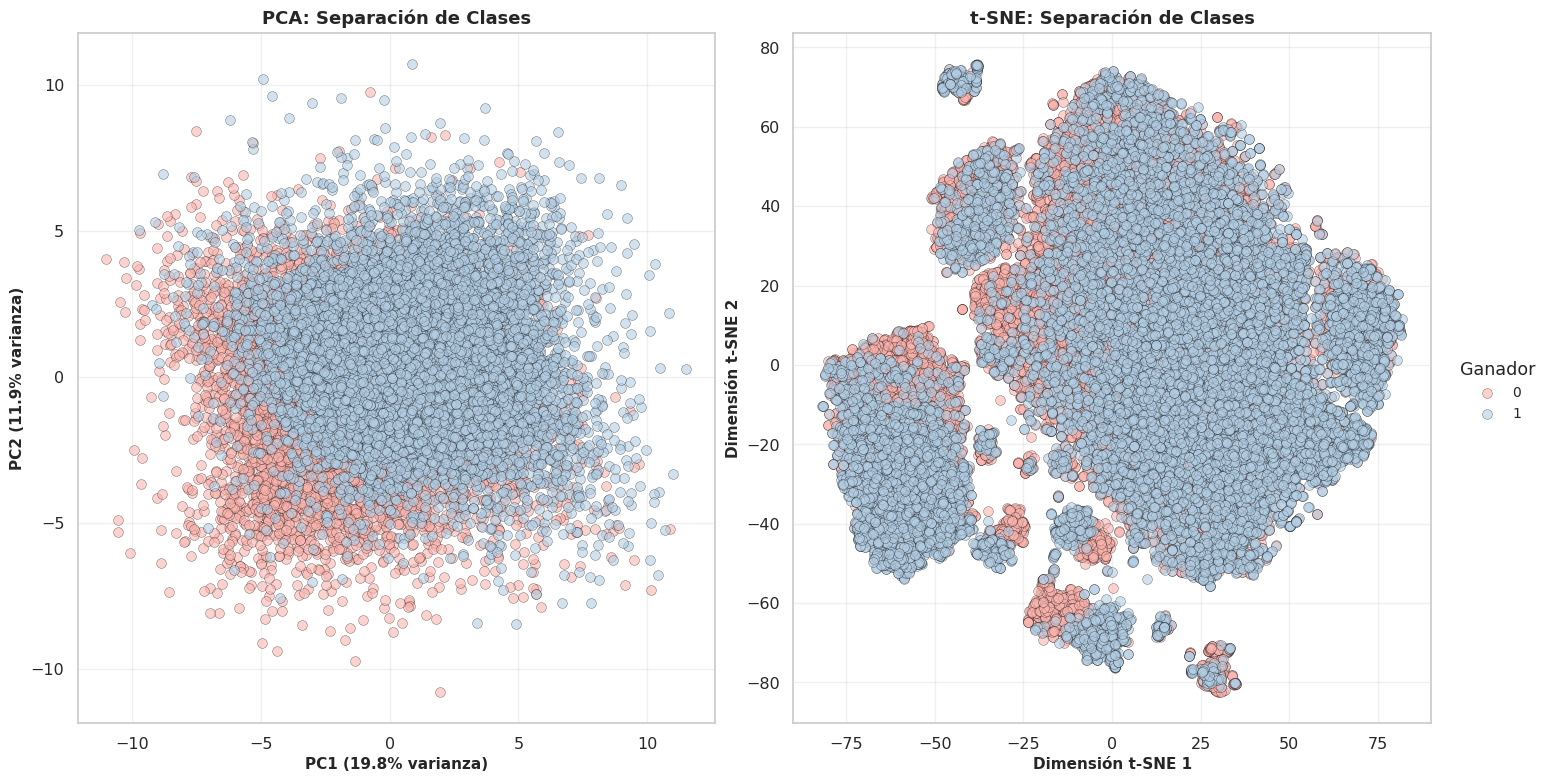

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

X_pca = next((globals().get(n) for n in ('X_train_pca','pca_result') if globals().get(n) is not None), None)
if X_pca is None:
    X_pca = myPCA.transform(X_train_processed)

evr = myPCA.explained_variance_ratio_
palette = sns.color_palette("Pastel1", n_colors=len(np.unique(y_train)))

# --- Gráfico 1: PCA ---
for i, obesity_class in enumerate(np.unique(y_train)):
    mask = (y_train == obesity_class).values if isinstance(y_train, pd.Series) else (y_train == obesity_class)
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    label=obesity_class, alpha=0.6, s=50,
                    color=palette[i % len(palette)], edgecolors='black', linewidth=0.3)

axes[0].set_xlabel(f'PC1 ({evr[0]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({evr[1]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
axes[0].set_title('PCA: Separación de Clases', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# --- Gráfico 2: t-SNE ---
for i, obesity_class in enumerate(np.unique(y_train)):
    mask = (y_train == obesity_class).values if isinstance(y_train, pd.Series) else (y_train == obesity_class)
    axes[1].scatter(X_train_tsne[mask, 0], X_train_tsne[mask, 1],
                    label=obesity_class, alpha=0.6, s=50,
                    color=palette[i % len(palette)], edgecolors='black', linewidth=0.3)

axes[1].set_xlabel('Dimensión t-SNE 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Dimensión t-SNE 2', fontsize=11, fontweight='bold')
axes[1].set_title('t-SNE: Separación de Clases', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
plt.subplots_adjust(right=0.9) 

fig.legend(handles, labels, title='Ganador',
           loc='center left',           
           bbox_to_anchor=(0.91, 0.5),  
           fontsize=10,
           frameon=False)               

plt.show()

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 2-Ajuste a modelos

## 0. Definiciones 

NOTA: Antes de empezar, definiremos las métricas que usaremos durante los ajustes. Partiendo de la matriz de confusión clásica, definida como:

* **TP (Verdaderos Positivos):** El modelo predijo que gana P1 y ganó P1.
* **TN (Verdaderos Negativos):** El modelo predijo que gana P2 (target=0) y ganó P2.
* **FP (Falsos Positivos):** El modelo predijo que gana P1, pero ganó P2.
* **FN (Falsos Negativos):** El modelo predijo que gana P2, pero ganó P1.

Hemos barajado diferentes **scoring systems**:

1. `Accuracy:` Mide el porcentaje total de aciertos sobre el total de partidos.
2. `Precision:` Mide la calidad de las predicciones positivas.
3. `Recall:` Mide la capacidad de encontrar todos los casos positivos.
4: `F1-score:` Es la media armónica entre Precision y Recall.

**Conclusión:** Dado que no existe desbalance de clases y que los errores de predicción son simétricos en coste, maximizaremos el **Accuracy**.



---


Para asegurarnos de que todos los modelos siguen las mismas condiciones y no hay sesgos, vamos a hacer el ajuste con una misma función.

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.base import clone
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, CategoricalDistribution, IntDistribution


# 1. CONFIGURACIÓN
RND = 16                
MAX_ITER = 1000        
SCORING_SYSTEM = 'accuracy' 
N_CV = 5            

# Corregido el error de 'Cyans' -> Usamos 'GnBu'
COLOR_MAP_ANSI = {
    'Blues': '\033[1;34m',    
    'GnBu': '\033[1;36m',   
    'Purples': '\033[1;35m',  
    'Greens': '\033[1;32m',   
    'Oranges': '\033[1;33m',  
    'Reds': '\033[1;31m',    
    'Greys': '\033[1;37m',
    'Golds': '\033[1;93m',
    'YlOrBr': '\033[1;33m'    # Amarillo-Naranja para Stacking
}
RESET_CODE = '\033[0m'

MODEL_TO_CMAP = {
    'LogisticRegression': 'Blues',
    'KNeighborsClassifier': 'GnBu', # Corregido
    'SVC': 'Purples', 
    'LinearSVC': 'Purples',
    'RandomForestClassifier': 'Greens',
    'XGBClassifier': 'Oranges',
    'MLPClassifier': 'Reds',         
    'VotingClassifier': 'Greys',      
    'StackingClassifier': 'YlOrBr'   # Color distintivo para Stacking
}

# 2. FUNCIÓN MAESTRA ADAPTADA A TIME SERIES
def ejecutar_modelo(modelo, params, X_train, y_train, preprocessor=preprocessor, 
                    cv=5, scoring='accuracy', tipo_busqueda='grid', n_iter=20):
    
    # 1. Configuración de TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # 2. Pipeline
    steps = []
    if preprocessor:
        steps.append(('preprocessor', preprocessor))
    steps.append(('clf', modelo))
    pipeline = Pipeline(steps)
    
    # 3. Ajuste de nombres de parámetros
    # IMPORTANTE: OptunaSearchCV necesita los nombres con 'clf__' igual que GridSearch
    pipeline_params = {f'clf__{k}': v for k, v in params.items()}
    
    model_name = modelo.__class__.__name__
    cmap = MODEL_TO_CMAP.get(model_name, 'Blues')
    ansi_color = COLOR_MAP_ANSI.get(cmap, '\033[1;34m')

    print(f"\n{ansi_color}--- Iniciando entrenamiento de {model_name} ---{RESET_CODE}")
    print(f"Modo: {tipo_busqueda.upper()} search | CV: TimeSeriesSplit ({cv} splits)")

    # 4. BUSQUEDA (Grid, Random u OPTUNA)
    if tipo_busqueda == 'grid':
        search = GridSearchCV(
            pipeline, pipeline_params, cv=tscv, scoring=scoring, n_jobs=-1, verbose=1
        )
    elif tipo_busqueda == 'random':
        search = RandomizedSearchCV(
            pipeline, pipeline_params, n_iter=n_iter, cv=tscv, scoring=scoring, 
            n_jobs=1, verbose=1, random_state=RND
        )
    # --- NUEVO BLOQUE OPTUNA ---
    elif tipo_busqueda == 'optuna':
        search = OptunaSearchCV(
            pipeline, 
            pipeline_params, 
            cv=tscv, 
            scoring=scoring, 
            n_trials=n_iter,    # En Optuna se llaman 'trials'
            random_state=RND,
            n_jobs=-1,          # Optuna puede paralelizar
            verbose=1
        )
    else:
        raise ValueError("tipo_busqueda debe ser 'grid', 'random' u 'optuna'")

    # 5. ENTRENAMIENTO PRINCIPAL
    # Optuna a veces es muy ruidoso, suprimimos logs leves si quieres
    optuna.logging.set_verbosity(optuna.logging.WARNING) 
    search.fit(X_train, y_train)
    
    # 6. RESULTADOS
    print(f"\n--- Mejores Parámetros ({model_name}): {search.best_params_} ---")
    print(f"{ansi_color}>>> Best Time-Series CV {scoring.upper()}: {search.best_score_:.4f}{RESET_CODE}")
    
    # 7. PREDICCIONES HONESTAS (TU LOOP MANUAL - SE MANTIENE IGUAL)
    print("Generando predicciones validación cruzada temporal...")
    best_pipeline = search.best_estimator_
    actual_y = []
    predicted_y = []
    
    for train_index, test_index in tscv.split(X_train):
        fold_pipeline = clone(best_pipeline)
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        fold_pipeline.fit(X_train_fold, y_train_fold)
        fold_preds = fold_pipeline.predict(X_test_fold)
        actual_y.extend(y_test_fold)
        predicted_y.extend(fold_preds)

    y_train_valid = np.array(actual_y)
    y_pred_cv = np.array(predicted_y)

    # 8. REPORTE
    print(f"\nResultados ({len(y_train_valid)} partidos evaluados):")
    report_dict = classification_report(y_train_valid, y_pred_cv, output_dict=True)
    style = pd.DataFrame(report_dict).transpose().style.background_gradient(
        cmap=cmap, subset=['precision', 'recall', 'f1-score'], vmin=0, vmax=1
    ).format("{:.3f}")
    display(style)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_train_valid, y_pred_cv, cmap=cmap, colorbar=False, ax=ax, values_format='d')
    ax.set_title(f"Confusion Matrix ({model_name})", pad=15)
    ax.grid(False)
    plt.show()
    
    return search


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase A: Modelos líneales/cuadráticos

## A.1-Regresión logística



--- Iniciando entrenamiento de LogisticRegression ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (LogisticRegression): {'clf__C': 0.0028150796685561122, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'clf__class_weight': 'balanced'} ---
>>> Best Time-Series CV ACCURACY: 0.6803
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


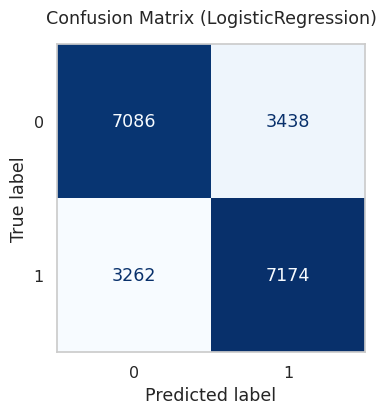

In [17]:
from sklearn.linear_model import LogisticRegression
# Importamos las distribuciones necesarias
from optuna.distributions import FloatDistribution, CategoricalDistribution

# 1. Definimos el espacio de búsqueda ESTILO OPTUNA
# Fíjate que en vez de listas fijas, definimos rangos continuos
param_dist_lr = {
    'C': FloatDistribution(1e-3, 1e3, log=True),  # Busca CUALQUIER valor entre 0.001 y 1000
    'penalty': CategoricalDistribution(['l1', 'l2']),
    'solver': CategoricalDistribution(['liblinear']),
    'class_weight': CategoricalDistribution(['balanced', None])
}

lr_model = LogisticRegression(max_iter=MAX_ITER, random_state=RND)

# 2. Ejecutamos con tipo_busqueda='optuna'
# Optuna necesita más iteraciones (n_iter) para converger bien, prueba con 30 o 50
grid_log = ejecutar_modelo(
    lr_model, 
    param_dist_lr, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',  # <--- CAMBIO AQUÍ
    n_iter=25                # Optuna es rápido, dale 30-50 intentos
)

best_lr = grid_log.best_estimator_

---

## A.2-K Nearest Neighbors



--- Iniciando entrenamiento de KNeighborsClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (KNeighborsClassifier): {'clf__n_neighbors': 27, 'clf__weights': 'distance', 'clf__p': 2} ---
>>> Best Time-Series CV ACCURACY: 0.6772
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


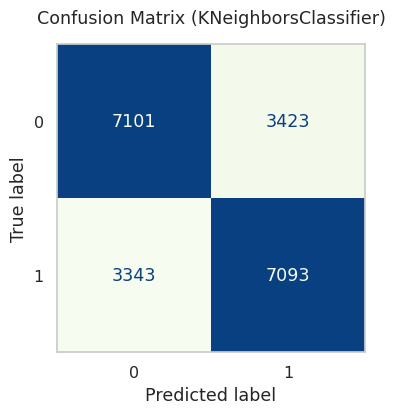

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from optuna.distributions import IntDistribution, CategoricalDistribution

# 1. Definimos el espacio de búsqueda ESTILO OPTUNA
param_dist_knn = {
    # IntDistribution permite 'step'. Así forzamos saltos de 2 en 2 (solo impares)
    'n_neighbors': IntDistribution(1, 29, step=2),
    'weights': CategoricalDistribution(['uniform', 'distance']),
    'p': CategoricalDistribution([1, 2])  # 1=Manhattan, 2=Euclidean
}

knn_model = KNeighborsClassifier()

# 2. Ejecutamos con Optuna
grid_knn = ejecutar_modelo(
    knn_model, 
    param_dist_knn, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',  # <--- Activamos Optuna
    n_iter=25                # 30 pruebas suelen ser suficientes para KNN
)

best_knn = grid_knn.best_estimator_

---

## A.3-SVM líneal


--- Iniciando entrenamiento de LinearSVC ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (LinearSVC): {'clf__C': 0.0014135463173059336, 'clf__loss': 'squared_hinge', 'clf__fit_intercept': True, 'clf__class_weight': None} ---
>>> Best Time-Series CV ACCURACY: 0.6801
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


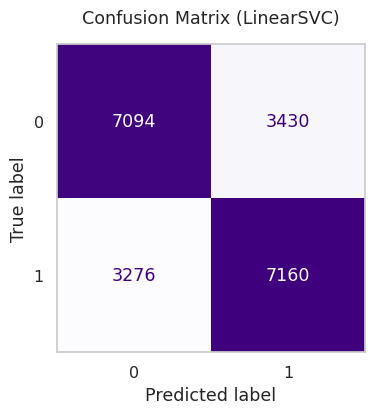

In [19]:
from sklearn.svm import LinearSVC
from optuna.distributions import FloatDistribution, CategoricalDistribution

# 1. Definimos el espacio de búsqueda ESTILO OPTUNA
param_dist_svm = {
    # Buscamos C en escala logarítmica (de 0.001 a 1000)
    'C': FloatDistribution(1e-3, 1e3, log=True),
    
    # IMPORTANTE: Si dual=False, solo se admite 'squared_hinge'.
    # 'hinge' requiere dual=True. Para evitar errores, dejamos solo squared_hinge
    # o podrías hacer 'dual' un hiperparámetro también.
    'loss': CategoricalDistribution(['squared_hinge']), 
    
    'fit_intercept': CategoricalDistribution([True, False]),
    'class_weight': CategoricalDistribution([None, 'balanced'])
}

# dual=False es preferible cuando n_samples > n_features
svm_model = LinearSVC(dual=False, random_state=RND, max_iter=MAX_ITER)

# 2. Ejecutamos con Optuna
grid_svm = ejecutar_modelo(
    svm_model, 
    param_dist_svm, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',
    n_iter=25   # LinearSVC es rápido, 30-50 iteraciones están bien
)

best_svm = grid_svm.best_estimator_

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B: Modelos no líneales

## B.1-Random Forest





--- Iniciando entrenamiento de RandomForestClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (RandomForestClassifier): {'clf__n_estimators': 247, 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 1} ---
>>> Best Time-Series CV ACCURACY: 0.6945
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


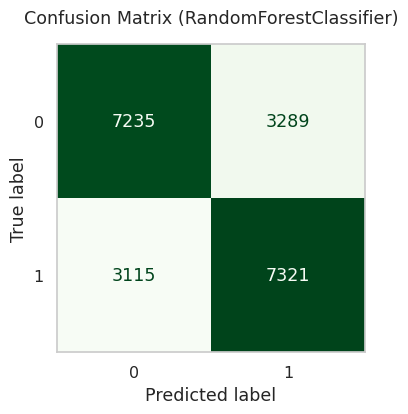

In [20]:
from sklearn.ensemble import RandomForestClassifier
from optuna.distributions import IntDistribution, CategoricalDistribution

# 1. Definimos el espacio de búsqueda ESTILO OPTUNA
param_dist_rf = {
    # Exploramos de 10 a 300 árboles. 
    # log=True da prioridad a explorar bien los valores bajos (donde los cambios importan más)
    'n_estimators': IntDistribution(10, 300, log=True),
    
    'criterion': CategoricalDistribution(['gini', 'entropy']),
    
    # Optuna prefiere rangos numéricos limpios.
    # En lugar de [None, 1, 2...], usamos de 1 a 30. 
    # 30 de profundidad es prácticamente "sin límite" para la mayoría de datasets.
    'max_depth': IntDistribution(1, 30),
    
    # Regularización suave
    'min_samples_leaf': IntDistribution(1, 15)
}

# n_jobs=4 deja que cada modelo use 4 cores. 
# Si tu función maestra también paraleliza (n_jobs=-1), esto evita que explote la CPU.
rf_model = RandomForestClassifier(random_state=RND, n_jobs=4)

# 2. Ejecutamos con Optuna
grid_rf = ejecutar_modelo(
    rf_model, 
    param_dist_rf, 
    X_train, 
    y_train,
    tipo_busqueda='optuna',
    n_iter=25  # RF es lento, 20 pruebas es un buen punto de partida
)

best_rf = grid_rf.best_estimator_

---

## B.2-XGBoost


--- Iniciando entrenamiento de XGBClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (XGBClassifier): {'clf__n_estimators': 523, 'clf__learning_rate': 0.01851697194041473, 'clf__max_depth': 4, 'clf__subsample': 0.789557486760989, 'clf__colsample_bytree': 0.8996036961729756, 'clf__gamma': 2.63824665487096, 'clf__reg_alpha': 9.231197315531594e-05, 'clf__reg_lambda': 9.618812169266158e-06} ---
>>> Best Time-Series CV ACCURACY: 0.7054
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


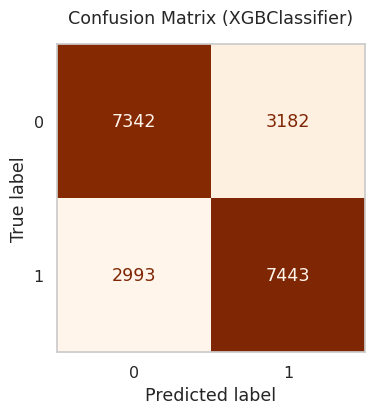

In [21]:
from xgboost import XGBClassifier
from optuna.distributions import FloatDistribution, IntDistribution

# 1. Espacio de búsqueda (Igual que antes, sirve para CPU y GPU)
param_dist_xgb = {
    'n_estimators': IntDistribution(100, 600), 
    'learning_rate': FloatDistribution(0.005, 0.3, log=True), 
    'max_depth': IntDistribution(3, 10),
    'subsample': FloatDistribution(0.5, 1.0),
    'colsample_bytree': FloatDistribution(0.5, 1.0),
    'gamma': FloatDistribution(0, 5.0),
    'reg_alpha': FloatDistribution(1e-8, 10.0, log=True), 
    'reg_lambda': FloatDistribution(1e-8, 10.0, log=True) 
}

# 2. Definición del Modelo para CPU (VS Code Local)
xgb_model = XGBClassifier(
    random_state=RND, 
    
    # ESTRATEGIA DE NÚCLEOS:
    # Como tu función 'ejecutar_modelo' usa Optuna con n_jobs=-1 (todos los núcleos),
    # aquí ponemos n_jobs=1 para que cada modelo use 1 solo núcleo.
    # Así Optuna puede entrenar 8 o 16 modelos A LA VEZ (uno en cada núcleo).
    n_jobs=1,   
    
    objective='binary:logistic', 
    eval_metric='logloss',
    
    # --- CONFIGURACIÓN CPU OPTIMIZADA ---
    device='cpu',         # Forzamos CPU
    tree_method='hist',   # 'hist' es muchísimo más rápido que 'auto' o 'exact'
    # ------------------------------------
    
    enable_categorical=True
)

# 3. Ejecutar
# Optuna se encargará de poner tu CPU al 100% probando varias combinaciones a la vez
grid_xgb = ejecutar_modelo(
    xgb_model, 
    param_dist_xgb, 
    X_train, 
    y_train,
    tipo_busqueda='optuna', 
    n_iter=30 
)

best_xgb = grid_xgb.best_estimator_

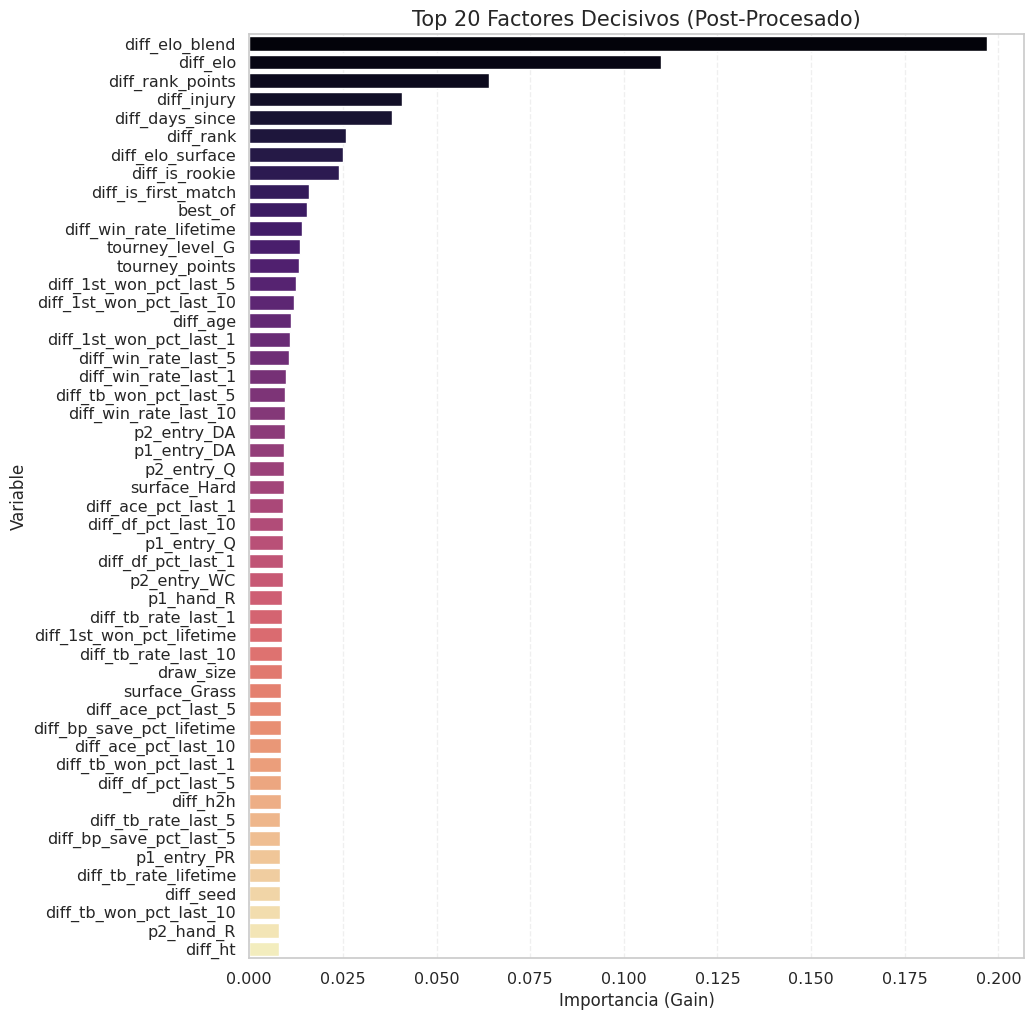

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraer el modelo puro y el preprocesador del Pipeline
xgboost_puro = best_xgb.named_steps['clf']
preprocessor = best_xgb.named_steps['preprocessor']

# 2. Extraer las importancias numéricas
importances = xgboost_puro.feature_importances_

# 3. --- EL TRUCO MAESTRO ---
# Pedimos al preprocesador los nombres REALES de salida (ej: Surface_Clay, Surface_Hard...)
# Esto asegura que la longitud coincida con las importancias.
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Si falla (versiones viejas de sklearn), creamos nombres genéricos
    print("⚠️ No se pudieron extraer nombres exactos. Usando genéricos.")
    feature_names = [f"Feature_{i}" for i in range(len(importances))]

# 4. Ahora sí, crear el DataFrame (longitudes coinciden seguro)
df_imp = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
})

# 5. Ordenar y Graficar el Top 20
df_imp = df_imp.sort_values('Importance', ascending=False).head(50)

plt.figure(figsize=(10, 12))
# Usamos 'viridis' o 'magma' para que quede profesional
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='magma')

plt.title('Top 20 Factores Decisivos (Post-Procesado)', fontsize=15)
plt.xlabel('Importancia (Gain)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

---

## B.3-Neural Networks


--- Iniciando entrenamiento de MLPClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (MLPClassifier): {'clf__hidden_layer_sizes': (50, 25), 'clf__activation': 'tanh', 'clf__alpha': 0.09082122433819029, 'clf__learning_rate_init': 0.004799817482287776, 'clf__batch_size': 64} ---
>>> Best Time-Series CV ACCURACY: 0.6937
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


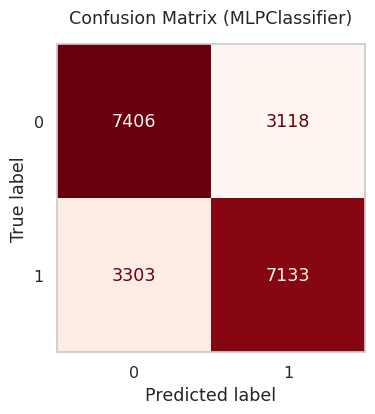

In [23]:
from sklearn.neural_network import MLPClassifier
from optuna.distributions import FloatDistribution, CategoricalDistribution

# 1. Configuración del Modelo (Mantenemos tu configuración "Turbo")
mlp_model = MLPClassifier(
    max_iter=1000, 
    early_stopping=True,     # Vital para que Optuna no pierda tiempo en modelos malos
    n_iter_no_change=10, 
    validation_fraction=0.1, 
    random_state=RND
)

# 2. Espacio de búsqueda ESTILO OPTUNA
param_dist_mlp = {
    # A. ARQUITECTURAS:
    # Optuna maneja tuplas perfectamente en CategoricalDistribution
    'hidden_layer_sizes': CategoricalDistribution([
        (32, 16),      # Tu campeona
        (50, 25),      # Hermana mayor
        (64, 32),      # Más capacidad
        (32, 32),      # Cuadrada
        (32, 16, 8)    # Profunda y ligera
    ]),

    # B. ACTIVACIÓN:
    'activation': CategoricalDistribution(['relu', 'tanh']),

    # C. REGULARIZACIÓN (Alpha): 
    # Usamos distribución continua logarítmica. 
    # Optuna buscará el valor exacto (ej: 0.034) entre 0.001 y 0.1
    'alpha': FloatDistribution(0.001, 0.1, log=True),

    # D. VELOCIDAD DE APRENDIZAJE:
    # Rango continuo logarítmico entre 0.001 y 0.01
    'learning_rate_init': FloatDistribution(0.001, 0.01, log=True),

    # E. BATCH SIZE:
    # Mantenemos las opciones discretas específicas
    'batch_size': CategoricalDistribution([64, 128, 256])
}

# 3. Ejecutar
# Las redes neuronales tardan en entrenar. 
# 25 iteraciones con Optuna suelen dar resultados excelentes porque descarta rápido lo que no funciona.
grid_mlp = ejecutar_modelo(
    mlp_model, 
    param_dist_mlp, 
    X_train, 
    y_train, 
    tipo_busqueda='optuna', 
    n_iter=10  
)

best_mlp = grid_mlp.best_estimator_

---

## B.4-SVM con Kernel


--- Iniciando entrenamiento de Pipeline ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (Pipeline): {'clf__nystroem__gamma': 0.015210073724899855, 'clf__nystroem__n_components': 464, 'clf__clf__alpha': 0.00019342468830041366, 'clf__clf__penalty': 'l1'} ---
>>> Best Time-Series CV ACCURACY: 0.6937
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


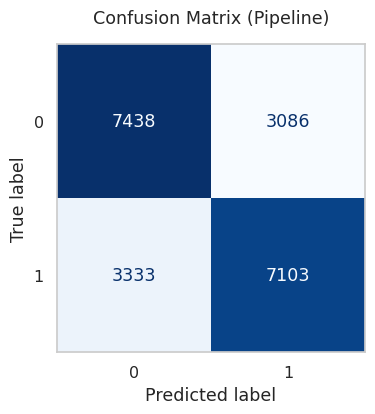

In [24]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

# 1. Definimos un Pipeline Especial
# Paso A: Nystroem "falsifica" el kernel RBF de forma ultra-rápida.
# Paso B: Usamos SGDClassifier (Linear) que vuela.
model_approx = Pipeline([
    ('nystroem', Nystroem(kernel='rbf', random_state=RND)),
    ('clf', SGDClassifier(loss='log_loss', random_state=RND, n_jobs=1)) # log_loss da probabilidades
])

# 2. Espacio de búsqueda para Optuna
param_dist_approx = {
    # Parámetros del mapa "falso" (Nystroem)
    'nystroem__gamma': FloatDistribution(0.001, 1.0, log=True),
    'nystroem__n_components': IntDistribution(100, 1000), # Cuántos "puntos de referencia" usar
    
    # Parámetros del clasificador lineal
    'clf__alpha': FloatDistribution(1e-5, 1e-1, log=True), # Regularización
    'clf__penalty': CategoricalDistribution(['l2', 'l1', 'elasticnet'])
}

# 3. Ejecutar
# Como esto es muy rápido, puedes darle 50 iteraciones sin miedo.
grid_svm_fast = ejecutar_modelo(
    model_approx, 
    param_dist_approx, 
    X_train, y_train, 
    tipo_busqueda='optuna', 
    n_iter=25
)

best_svm_fast = grid_svm_fast.best_estimator_

---

## B.5-Ensamble


--- Iniciando entrenamiento de VotingClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

--- Mejores Parámetros (VotingClassifier): {'clf__weights': [1, 2, 1, 1, 1, 1, 1]} ---
>>> Best Time-Series CV ACCURACY: 0.6978
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


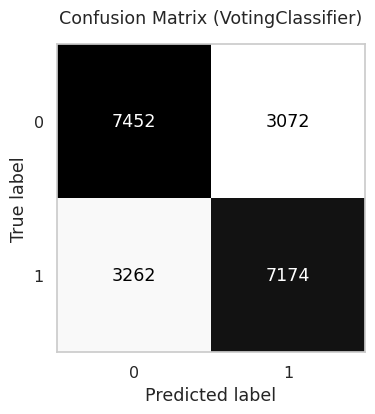

In [55]:
from sklearn.ensemble import VotingClassifier

# Extract just the classifiers from the pipelines (not the full pipeline)
estimators_list = [
    ('lr', best_lr.named_steps['clf']),
    ('knn', best_knn.named_steps['clf']),
    ('svc', best_svm.named_steps['clf']),
    ('rf', best_rf.named_steps['clf']),
    ('xgb', best_xgb.named_steps['clf']),
    ('mlp', best_mlp.named_steps['clf']),
    ('svm_k', best_svm_fast.named_steps['clf'])
]

voting_model = VotingClassifier(
    estimators=estimators_list,
    voting='hard', 
    n_jobs=1  # Changed to 1 to avoid memory issues
)

# Weights must have 6 elements (one per estimator)
param_grid_voting = {
    'weights': [
        [1, 1, 1, 1, 1, 1, 1],  # Equal weights
        [2, 1, 1, 1, 1, 1, 1],  # Favor LR
        [1, 2, 1, 1, 1, 1, 1],  # Favor KNN
        [1, 1, 2, 1, 1, 1, 1],  # Favor SVC
        [1, 1, 1, 2, 1, 1, 1],  # Favor RF
        [1, 1, 1, 1, 2, 1, 1],  # Favor XGB
        [1, 1, 1, 1, 1, 2, 1],  # Favor MLP
        [2, 1, 1, 2, 2, 1, 1],  # Favor tree-based + LR
        [1, 1, 1, 2, 2, 2, 1],  # Favor non-linear models
    ],
}

grid_voting = ejecutar_modelo(
    voting_model, 
    param_grid_voting, 
    X_train,  
    y_train,
    tipo_busqueda='random',
    n_iter=5  # Only try 5 random combinations to save memory
)

best_voting = grid_voting.best_estimator_


--- Iniciando entrenamiento de VotingClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- Mejores Parámetros (VotingClassifier): {'clf__weights': [3, 2, 1]} ---
>>> Best Time-Series CV ACCURACY: 0.7029
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


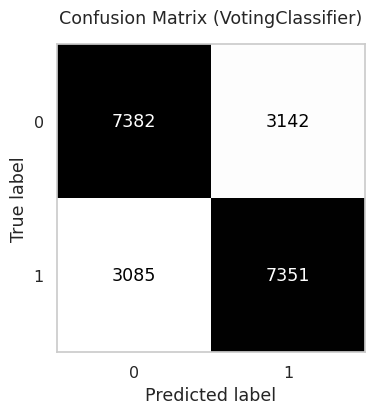

In [45]:
from sklearn.ensemble import VotingClassifier

# Optimized Elite List
# We keep only the top performers from different "families" of algorithms
estimators_list = [
    ('xgb', best_xgb.named_steps['clf']),
    ('mlp', best_mlp.named_steps['clf']),
    ('lr', best_lr.named_steps['clf'])
]

voting_model = VotingClassifier(
    estimators=estimators_list,
    voting='soft', # CHANGE TO SOFT: This uses probabilities (AUC) rather than just 0/1
    n_jobs=1 
)

# New Weights Strategy
# Since XGBoost is your clear winner, we want to test giving it more 'voting power'
param_grid_voting = {
    'weights': [
        [1, 1, 1], # Equal voice
        [2, 1, 1], # Favor the Gradient Boosting (XGB)
        [3, 2, 1], # Tiered weighting (XGB > MLP > LR)
        [2, 2, 1], # Favor non-linear (XGB + MLP) over linear
    ],
}

grid_voting_top3 = ejecutar_modelo(
    voting_model, 
    param_grid_voting, 
    X_train,  
    y_train,
    tipo_busqueda='random',
    n_iter=16 # Only 4 combinations needed for this slimmed list
)

best_voting_top3 = grid_voting.best_estimator_


--- Iniciando entrenamiento de StackingClassifier ---
Modo: OPTUNA search | CV: TimeSeriesSplit (5 splits)

--- Mejores Parámetros (StackingClassifier): {'clf__final_estimator__C': 8.502093781638527, 'clf__passthrough': False} ---
>>> Best Time-Series CV ACCURACY: 0.7044
Generando predicciones validación cruzada temporal...

Resultados (20960 partidos evaluados):


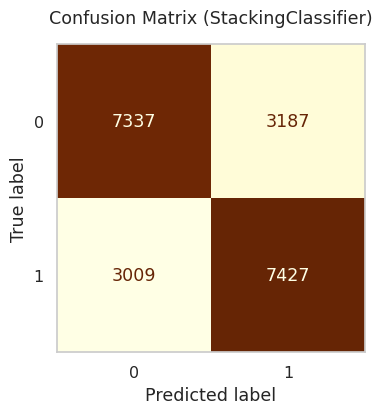

In [56]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from optuna.distributions import FloatDistribution, CategoricalDistribution

# 1. Definimos los estimadores base (Elite Three)
estimators_stack = [
    ('xgb', best_xgb.named_steps['clf']),
    ('mlp', best_mlp.named_steps['clf']),
    ('lr', best_lr.named_steps['clf'])
]

# 2. Definimos el StackingClassifier
# El meta-modelo aprenderá a combinar las probabilidades de los 3 base
stacking_model = StackingClassifier(
    estimators=estimators_stack,
    final_estimator=LogisticRegression(max_iter=2000),
    cv=5, 
    stack_method='predict_proba',
    n_jobs=1
)

# 3. Espacio de búsqueda para Optuna
# Optimizamos el meta-modelo (final_estimator)
param_dist_stack = {
    # Buscamos la regularización óptima para el meta-modelo
    'final_estimator__C': FloatDistribution(1e-3, 1e2, log=True),
    
    # Podemos decidir si el meta-modelo ve solo las predicciones o también los datos originales
    'passthrough': CategoricalDistribution([True, False])
}

# 4. Ejecutar entrenamiento con Optuna
grid_stacking_opt = ejecutar_modelo(
    stacking_model, 
    param_dist_stack, 
    X_train,  
    y_train,
    tipo_busqueda='optuna',
    n_iter=15 # Suficiente para encontrar el balance de pesos
)

best_stacking_top3 = grid_stacking_opt.best_estimator_

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 3-Comparación de los modelos 

## Introducción

En este apartado compararemos el rendimiento de todos los modelos entrenados, tanto lineales como no lineales, para determinar cuál es el mejor modelo para predecir el ganador de un partido de tenis.

**Criterio de evaluación:**
- **Criterio principal**: Score de validación cruzada (CV Score) obtenido durante el GridSearch/RandomSearch
- **Criterio secundario**: Score en el conjunto de test para verificar generalización
- **Detección de overfitting**: Diferencia entre CV Score y Test Score

**Clasificación de modelos:**
- **Modelos Lineales**: Logistic Regression, Linear SVM, K-Nearest Neighbors
- **Modelos No Lineales**: Random Forest, XGBoost, MLP (Neural Network)
- **Ensemble**: Voting Classifier, Stacking Classifier (metamodelo que combina todos)

## 3.1 - Recopilación de Resultados

Primero recopilaremos todos los scores de validación cruzada y evaluaremos cada modelo en el conjunto de test.

In [57]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Diccionario con todos los modelos entrenados
models_dict = {
    'Logistic Regression': grid_log,
    'Linear SVM': grid_svm,
    'K-Nearest Neighbors': grid_knn,
    'Random Forest': grid_rf,
    'XGBoost': grid_xgb,
    'MLP (Neural Network)': grid_mlp,
    'Voting Ensemble': grid_voting,
    'best_voting_top3': grid_voting_top3,
    'SVM with Kernel': grid_svm_fast,
    'best_stacking_top3': grid_stacking_opt
}

# Clasificación de modelos por tipo
linear_models = ['Logistic Regression', 'Linear SVM', 'K-Nearest Neighbors']
nonlinear_models = ['Random Forest', 'XGBoost', 'MLP (Neural Network)']
ensemble_models = ['Voting Ensemble', 'Stacking Ensemble']

# Recopilar resultados de todos los modelos
results = []
for name, grid in models_dict.items():
    cv_score = grid.best_score_
    
    # Predecir en test
    y_pred_test = grid.best_estimator_.predict(X_test)
    test_score = accuracy_score(y_test, y_pred_test)
    
    # Calcular diferencia (para detectar overfitting)
    diff = cv_score - test_score
    
    # Clasificar el modelo por tipo
    if name in linear_models:
        model_type = 'Linear'
    elif name in nonlinear_models:
        model_type = 'Non-Linear'
    else:
        model_type = 'Ensemble'
    
    results.append({
        'Modelo': name,
        'Tipo': model_type,
        'CV Score': cv_score,
        'Test Score': test_score,
        'Diferencia (CV - Test)': diff
    })

# Crear DataFrame de resultados
df_results = pd.DataFrame(results).sort_values('CV Score', ascending=False)

print("="*100)
print(" " * 35 + "RESUMEN DE TODOS LOS MODELOS")
print("="*100)
display(df_results.style.background_gradient(cmap='RdYlGn', subset=['CV Score', 'Test Score'])
                        .format({'CV Score': '{:.4f}', 'Test Score': '{:.4f}', 'Diferencia (CV - Test)': '{:.4f}'}))

                                   RESUMEN DE TODOS LOS MODELOS


## 3.2 - Comparación de Modelos Lineales

Comparemos en detalle los modelos lineales: **Logistic Regression**, **Linear SVM** y **K-Nearest Neighbors**.

                         MODELOS LINEALES


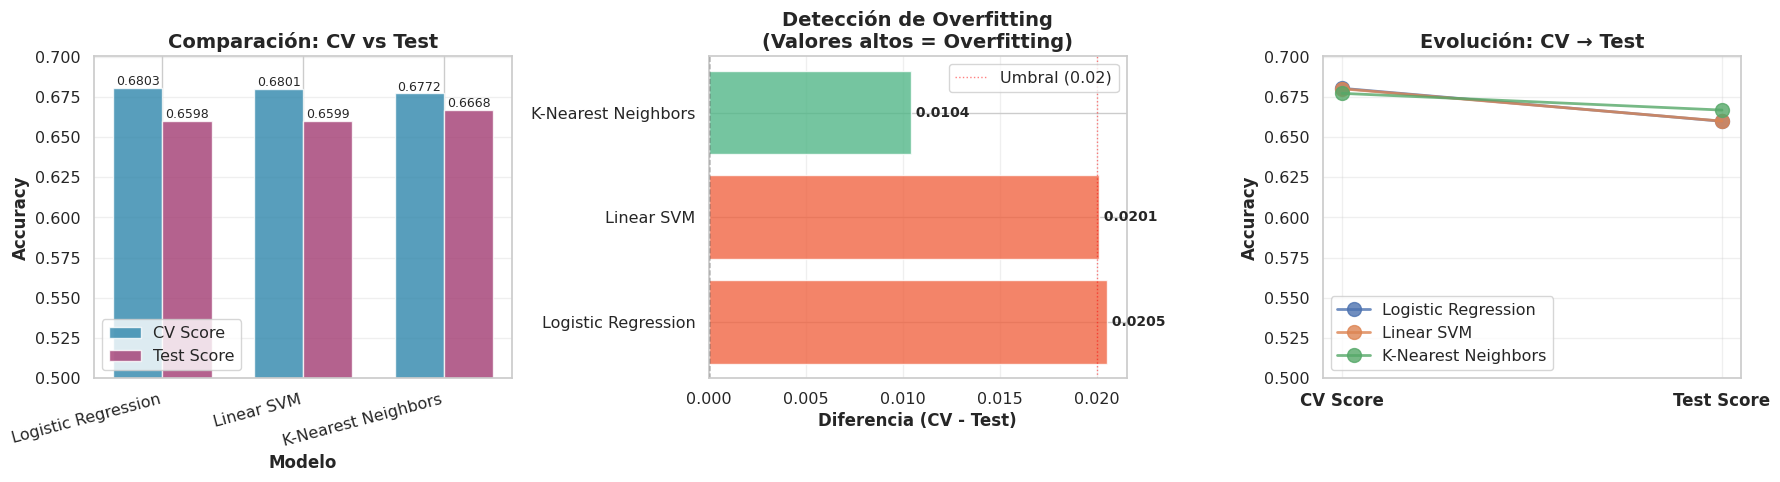


🏆 MEJOR MODELO LINEAL: Logistic Regression
   CV Score:   0.6803
   Test Score: 0.6598
   Diferencia: 0.0205



In [58]:
# Filtrar modelos lineales
df_linear = df_results[df_results['Tipo'] == 'Linear'].copy()

print("="*80)
print(" " * 25 + "MODELOS LINEALES")
print("="*80)
display(df_linear.style.background_gradient(cmap='RdYlGn', subset=['CV Score', 'Test Score'])
                       .format({'CV Score': '{:.4f}', 'Test Score': '{:.4f}', 'Diferencia (CV - Test)': '{:.4f}'}))

# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Gráfico de barras: CV vs Test
x = np.arange(len(df_linear))
width = 0.35

bars1 = axes[0].bar(x - width/2, df_linear['CV Score'], width, label='CV Score', alpha=0.8, color='#2E86AB')
bars2 = axes[0].bar(x + width/2, df_linear['Test Score'], width, label='Test Score', alpha=0.8, color='#A23B72')

axes[0].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación: CV vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_linear['Modelo'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.5, max(df_linear['CV Score'].max(), df_linear['Test Score'].max()) + 0.02])

# Añadir valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# 2. Detección de overfitting
colors = ['#F06543' if x > 0.02 else '#52B788' for x in df_linear['Diferencia (CV - Test)']]
axes[1].barh(df_linear['Modelo'], df_linear['Diferencia (CV - Test)'], color=colors, alpha=0.8)
axes[1].set_xlabel('Diferencia (CV - Test)', fontsize=12, fontweight='bold')
axes[1].set_title('Detección de Overfitting\n(Valores altos = Overfitting)', fontsize=14, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].axvline(0.02, color='red', linestyle=':', linewidth=1, alpha=0.5, label='Umbral (0.02)')
axes[1].grid(axis='x', alpha=0.3)
axes[1].legend()

# Añadir valores en las barras
for i, (idx, row) in enumerate(df_linear.iterrows()):
    axes[1].text(row['Diferencia (CV - Test)'], i, f" {row['Diferencia (CV - Test)']:.4f}", 
                va='center', fontsize=10, fontweight='bold')

# 3. Comparación lado a lado
x_pos = np.arange(2)  # CV Score, Test Score
for i, (idx, row) in enumerate(df_linear.iterrows()):
    scores = [row['CV Score'], row['Test Score']]
    axes[2].plot(x_pos, scores, marker='o', markersize=10, linewidth=2, label=row['Modelo'], alpha=0.8)
    
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(['CV Score', 'Test Score'], fontsize=12, fontweight='bold')
axes[2].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[2].set_title('Evolución: CV → Test', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)
axes[2].set_ylim([0.5, max(df_linear['CV Score'].max(), df_linear['Test Score'].max()) + 0.02])

plt.tight_layout()
plt.show()

# Mejor modelo lineal
best_linear = df_linear.iloc[0]
print(f"\n{'='*80}")
print(f"🏆 MEJOR MODELO LINEAL: {best_linear['Modelo']}")
print(f"{'='*80}")
print(f"   CV Score:   {best_linear['CV Score']:.4f}")
print(f"   Test Score: {best_linear['Test Score']:.4f}")
print(f"   Diferencia: {best_linear['Diferencia (CV - Test)']:.4f}")
print(f"{'='*80}\n")

### Evaluación detallada del mejor modelo lineal


Classification Report - Logistic Regression (Test Set)

               precision    recall  f1-score   support

Player 2 Wins       0.66      0.65      0.65      5421
Player 1 Wins       0.66      0.67      0.66      5500

     accuracy                           0.66     10921
    macro avg       0.66      0.66      0.66     10921
 weighted avg       0.66      0.66      0.66     10921



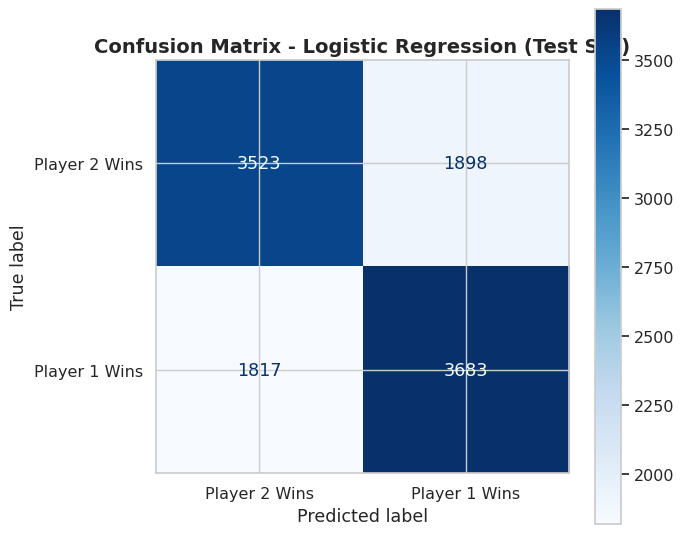

In [59]:
# Obtener el mejor modelo lineal
best_linear_name = best_linear['Modelo']
best_linear_grid = models_dict[best_linear_name]
y_pred_test = best_linear_grid.best_estimator_.predict(X_test)

print(f"\n{'='*80}")
print(f"Classification Report - {best_linear_name} (Test Set)")
print(f"{'='*80}\n")
print(classification_report(y_test, y_pred_test, target_names=['Player 2 Wins', 'Player 1 Wins']))

# Matriz de confusión
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues', ax=ax, 
                                        display_labels=['Player 2 Wins', 'Player 1 Wins'], values_format='d')
ax.set_title(f'Confusion Matrix - {best_linear_name} (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.3 - Comparación de Modelos No Lineales

Comparemos en detalle los modelos no lineales: **Random Forest**, **XGBoost** y **MLP (Neural Network)**.

                       MODELOS NO LINEALES


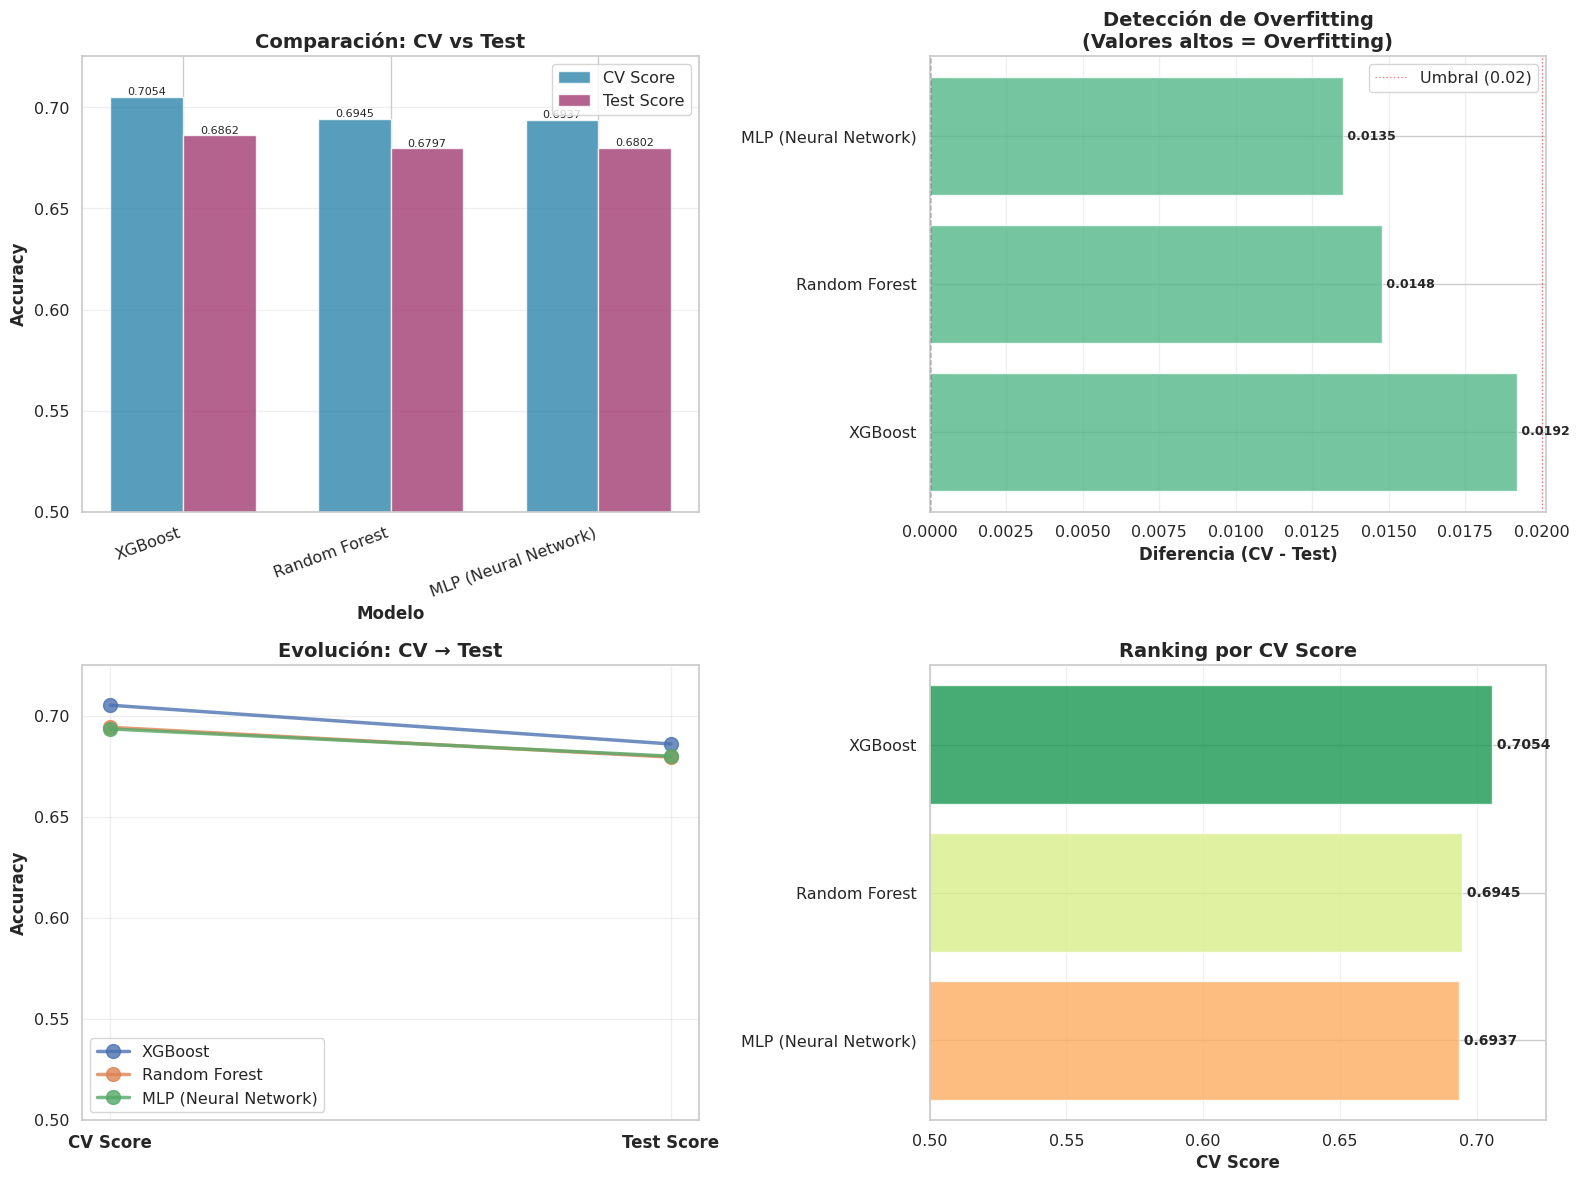


🏆 MEJOR MODELO NO LINEAL: XGBoost
   CV Score:   0.7054
   Test Score: 0.6862
   Diferencia: 0.0192



In [60]:
# Filtrar modelos no lineales
df_nonlinear = df_results[df_results['Tipo'] == 'Non-Linear'].copy()

print("="*80)
print(" " * 23 + "MODELOS NO LINEALES")
print("="*80)
display(df_nonlinear.style.background_gradient(cmap='RdYlGn', subset=['CV Score', 'Test Score'])
                          .format({'CV Score': '{:.4f}', 'Test Score': '{:.4f}', 'Diferencia (CV - Test)': '{:.4f}'}))

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de barras: CV vs Test
x = np.arange(len(df_nonlinear))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, df_nonlinear['CV Score'], width, label='CV Score', alpha=0.8, color='#2E86AB')
bars2 = axes[0, 0].bar(x + width/2, df_nonlinear['Test Score'], width, label='Test Score', alpha=0.8, color='#A23B72')

axes[0, 0].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Comparación: CV vs Test', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(df_nonlinear['Modelo'], rotation=20, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0.5, max(df_nonlinear['CV Score'].max(), df_nonlinear['Test Score'].max()) + 0.02])

# Añadir valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

# 2. Detección de overfitting
colors = ['#F06543' if x > 0.02 else '#52B788' for x in df_nonlinear['Diferencia (CV - Test)']]
axes[0, 1].barh(df_nonlinear['Modelo'], df_nonlinear['Diferencia (CV - Test)'], color=colors, alpha=0.8)
axes[0, 1].set_xlabel('Diferencia (CV - Test)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Detección de Overfitting\n(Valores altos = Overfitting)', fontsize=14, fontweight='bold')
axes[0, 1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[0, 1].axvline(0.02, color='red', linestyle=':', linewidth=1, alpha=0.5, label='Umbral (0.02)')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].legend()

# Añadir valores en las barras
for i, (idx, row) in enumerate(df_nonlinear.iterrows()):
    axes[0, 1].text(row['Diferencia (CV - Test)'], i, f" {row['Diferencia (CV - Test)']:.4f}", 
                   va='center', fontsize=9, fontweight='bold')

# 3. Comparación lado a lado
x_pos = np.arange(2)  # CV Score, Test Score
for i, (idx, row) in enumerate(df_nonlinear.iterrows()):
    scores = [row['CV Score'], row['Test Score']]
    axes[1, 0].plot(x_pos, scores, marker='o', markersize=10, linewidth=2.5, label=row['Modelo'], alpha=0.8)
    
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(['CV Score', 'Test Score'], fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Evolución: CV → Test', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='best')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0.5, max(df_nonlinear['CV Score'].max(), df_nonlinear['Test Score'].max()) + 0.02])

# 4. Ranking de modelos
sorted_df = df_nonlinear.sort_values('CV Score', ascending=True)
colors_rank = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sorted_df)))
axes[1, 1].barh(sorted_df['Modelo'], sorted_df['CV Score'], color=colors_rank, alpha=0.8)
axes[1, 1].set_xlabel('CV Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Ranking por CV Score', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].set_xlim([0.5, max(sorted_df['CV Score']) + 0.02])

# Añadir valores en las barras
for i, (idx, row) in enumerate(sorted_df.iterrows()):
    axes[1, 1].text(row['CV Score'], i, f" {row['CV Score']:.4f}", 
                   va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Mejor modelo no lineal
best_nonlinear = df_nonlinear.iloc[0]
print(f"\n{'='*80}")
print(f"🏆 MEJOR MODELO NO LINEAL: {best_nonlinear['Modelo']}")
print(f"{'='*80}")
print(f"   CV Score:   {best_nonlinear['CV Score']:.4f}")
print(f"   Test Score: {best_nonlinear['Test Score']:.4f}")
print(f"   Diferencia: {best_nonlinear['Diferencia (CV - Test)']:.4f}")
print(f"{'='*80}\n")

### Evaluación detallada del mejor modelo no lineal


Classification Report - XGBoost (Test Set)

               precision    recall  f1-score   support

Player 2 Wins       0.68      0.68      0.68      5421
Player 1 Wins       0.69      0.69      0.69      5500

     accuracy                           0.69     10921
    macro avg       0.69      0.69      0.69     10921
 weighted avg       0.69      0.69      0.69     10921



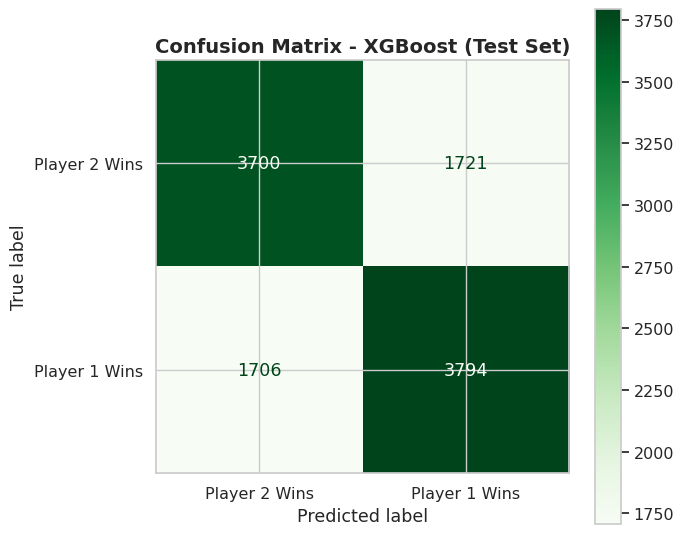

In [61]:
# Obtener el mejor modelo no lineal
best_nonlinear_name = best_nonlinear['Modelo']
best_nonlinear_grid = models_dict[best_nonlinear_name]
y_pred_test_nl = best_nonlinear_grid.best_estimator_.predict(X_test)

print(f"\n{'='*80}")
print(f"Classification Report - {best_nonlinear_name} (Test Set)")
print(f"{'='*80}\n")
print(classification_report(y_test, y_pred_test_nl, target_names=['Player 2 Wins', 'Player 1 Wins']))

# Matriz de confusión
fig, ax = plt.subplots(figsize=(7, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_nl, cmap='Greens', ax=ax,
                                        display_labels=['Player 2 Wins', 'Player 1 Wins'], values_format='d')
ax.set_title(f'Confusion Matrix - {best_nonlinear_name} (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.4 - Comparación Global: Lineales vs No Lineales vs Ensemble

Comparemos ahora todos los modelos juntos para determinar el ganador final.

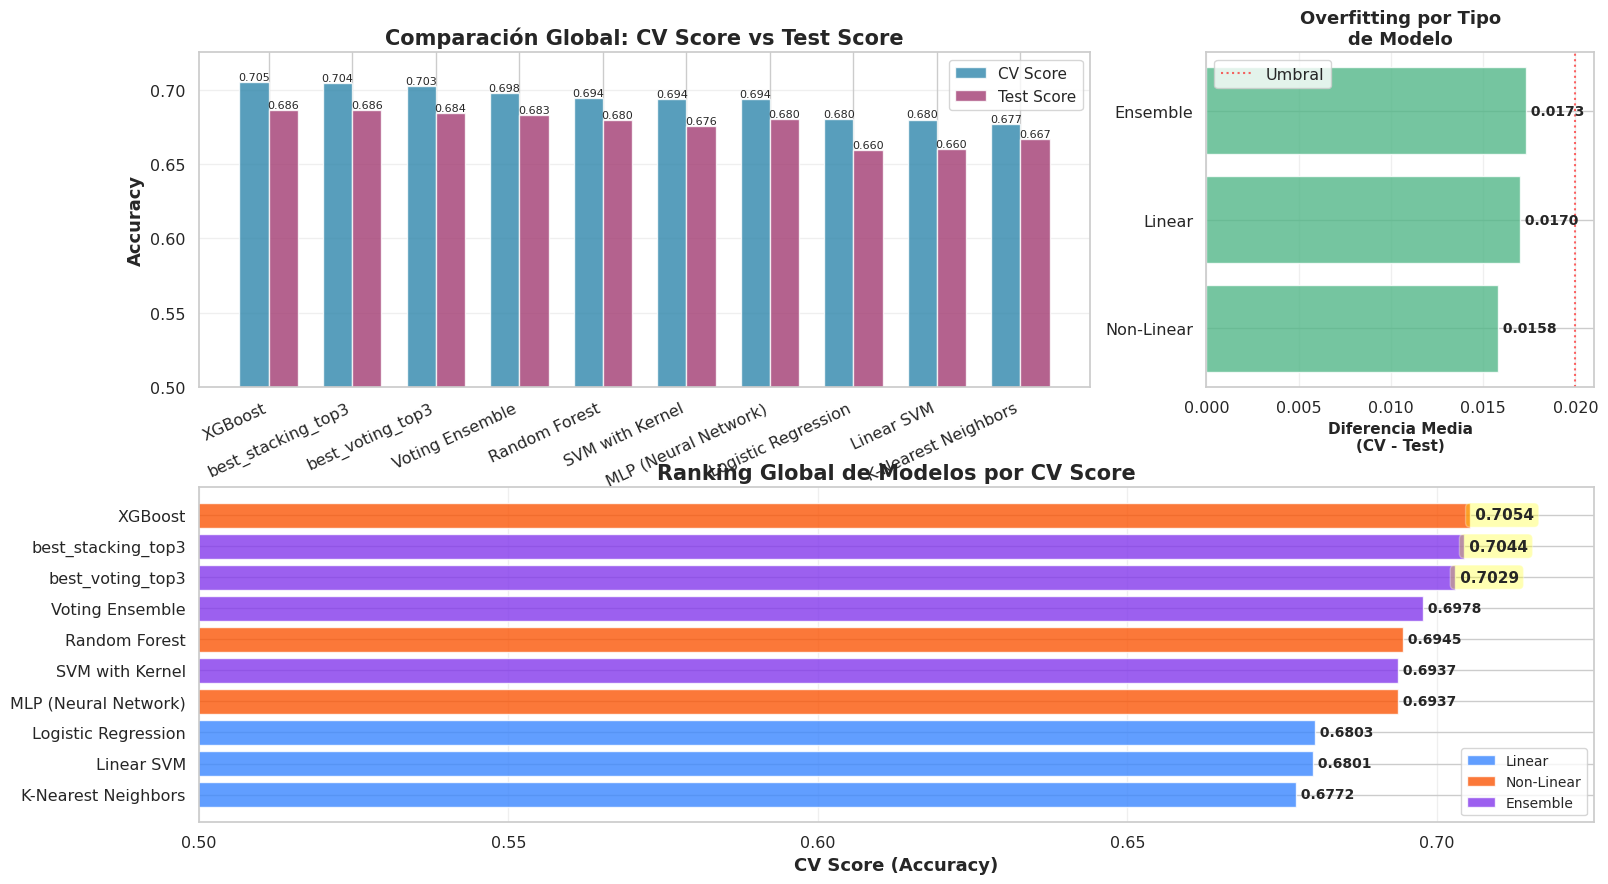


                                   ESTADÍSTICAS POR TIPO DE MODELO


CV Score                 Test Score                  \
               mean     max     min       mean     max     min   
Tipo                                                             
Ensemble     0.6997  0.7044  0.6938     0.6824  0.6865  0.6759   
Linear       0.6792  0.6803  0.6772     0.6622  0.6668  0.6598   
Non-Linear   0.6978  0.7054  0.6937     0.6820  0.6862  0.6797   

           Diferencia (CV - Test)          
                             mean     max  
Tipo                                       
Ensemble                   0.0173  0.0187  
Linear                     0.0170  0.0205  
Non-Linear                 0.0158  0.0192

In [62]:
# Visualización global comparativa
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Gráfico principal: Todos los modelos CV vs Test
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(df_results))
width = 0.35

bars1 = ax1.bar(x - width/2, df_results['CV Score'], width, label='CV Score', alpha=0.8, color='#2E86AB')
bars2 = ax1.bar(x + width/2, df_results['Test Score'], width, label='Test Score', alpha=0.8, color='#A23B72')

ax1.set_xlabel('Modelo', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('Comparación Global: CV Score vs Test Score', fontsize=15, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_results['Modelo'], rotation=25, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.5, max(df_results['CV Score'].max(), df_results['Test Score'].max()) + 0.02])

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Overfitting por tipo de modelo
ax2 = fig.add_subplot(gs[0, 2])
tipos = df_results.groupby('Tipo')['Diferencia (CV - Test)'].mean().sort_values()
colors_tipo = ['#52B788' if x < 0.02 else '#F06543' for x in tipos.values]
ax2.barh(tipos.index, tipos.values, color=colors_tipo, alpha=0.8)
ax2.set_xlabel('Diferencia Media\n(CV - Test)', fontsize=11, fontweight='bold')
ax2.set_title('Overfitting por Tipo\nde Modelo', fontsize=13, fontweight='bold')
ax2.axvline(0.02, color='red', linestyle=':', linewidth=1.5, alpha=0.6, label='Umbral')
ax2.grid(axis='x', alpha=0.3)
ax2.legend()

for i, v in enumerate(tipos.values):
    ax2.text(v, i, f' {v:.4f}', va='center', fontsize=10, fontweight='bold')

# 3. Ranking general (CV Score)
ax3 = fig.add_subplot(gs[1, :])
sorted_all = df_results.sort_values('CV Score', ascending=True)

# Colores por tipo
color_map = {'Linear': '#3A86FF', 'Non-Linear': '#FB5607', 'Ensemble': '#8338EC'}
colors_all = [color_map[t] for t in sorted_all['Tipo']]

bars = ax3.barh(sorted_all['Modelo'], sorted_all['CV Score'], color=colors_all, alpha=0.8)
ax3.set_xlabel('CV Score (Accuracy)', fontsize=13, fontweight='bold')
ax3.set_title('Ranking Global de Modelos por CV Score', fontsize=15, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
ax3.set_xlim([0.5, max(sorted_all['CV Score']) + 0.02])

# Añadir valores y destacar top 3
for i, (idx, row) in enumerate(sorted_all.iterrows()):
    text = f" {row['CV Score']:.4f}"
    if i >= len(sorted_all) - 3:  # Top 3
        ax3.text(row['CV Score'], i, text, va='center', fontsize=11, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    else:
        ax3.text(row['CV Score'], i, text, va='center', fontsize=10, fontweight='bold')

# Leyenda de tipos
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[tipo], alpha=0.8, label=tipo) 
                  for tipo in ['Linear', 'Non-Linear', 'Ensemble']]
ax3.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print(" " * 35 + "ESTADÍSTICAS POR TIPO DE MODELO")
print("="*100)
stats_by_type = df_results.groupby('Tipo').agg({
    'CV Score': ['mean', 'max', 'min'],
    'Test Score': ['mean', 'max', 'min'],
    'Diferencia (CV - Test)': ['mean', 'max']
}).round(4)
display(stats_by_type)

## 3.5 - Curvas ROC: Análisis de Discriminación

Las curvas ROC nos permiten evaluar la capacidad de cada modelo para discriminar entre las dos clases.

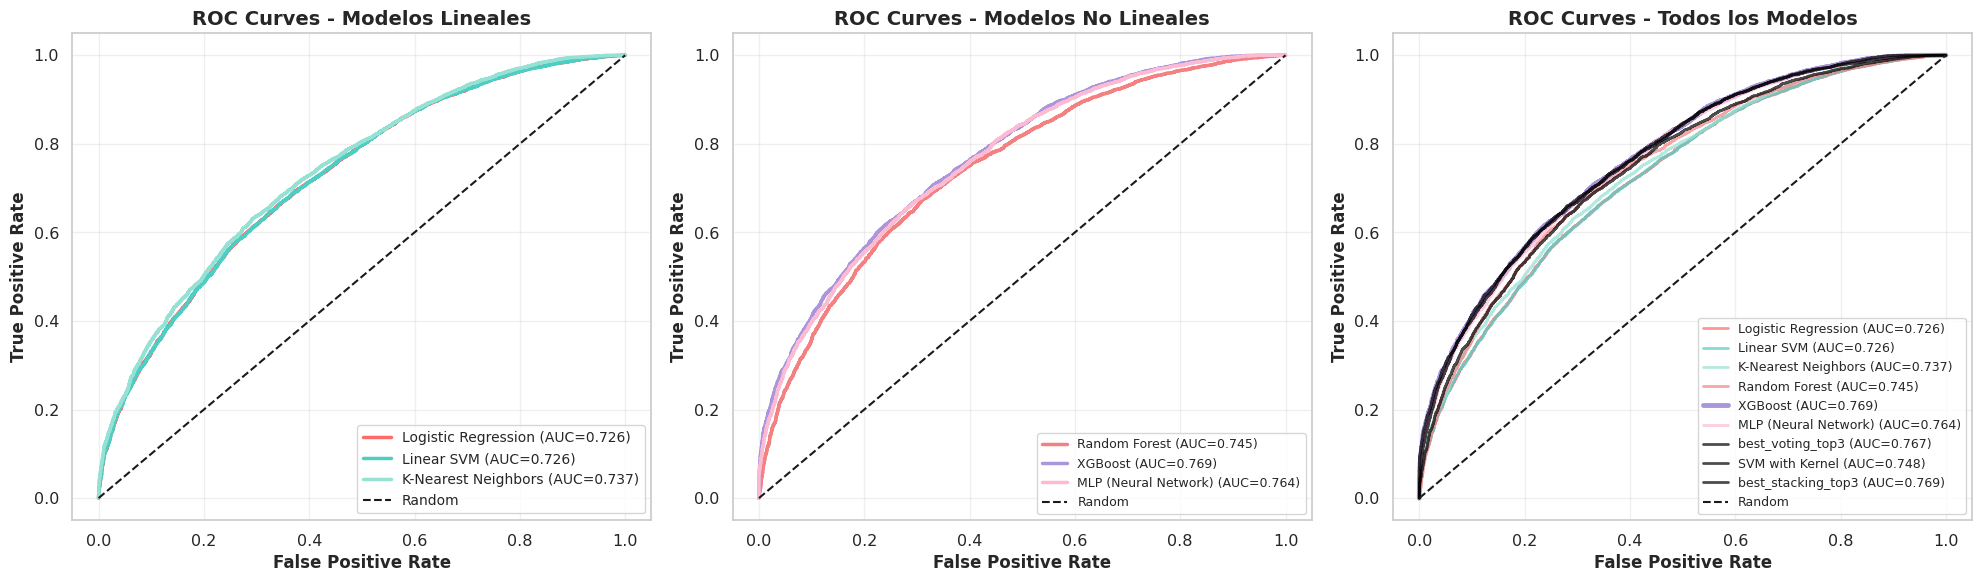


                              AUC SCORES


In [63]:
# Curvas ROC por categoría
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Definir colores por modelo
model_colors = {
    'Logistic Regression': '#FF6B6B',
    'Linear SVM': '#4ECDC4',
    'K-Nearest Neighbors': '#95E1D3',
    'Random Forest': '#F38181',
    'XGBoost': '#AA96DA',
    'MLP (Neural Network)': '#FCBAD3',
    'Voting Ensemble': '#FFFFD2'
}

auc_scores = {}

# 1. Modelos Lineales
for name in linear_models:
    grid = models_dict[name]
    try:
        if hasattr(grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba = grid.best_estimator_.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        auc_scores[name] = auc
        
        axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', 
                    linewidth=2.5, color=model_colors.get(name, 'black'))
    except:
        pass

axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curves - Modelos Lineales', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

# 2. Modelos No Lineales
for name in nonlinear_models:
    grid = models_dict[name]
    try:
        if hasattr(grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba = grid.best_estimator_.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        auc_scores[name] = auc
        
        axes[1].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', 
                    linewidth=2.5, color=model_colors.get(name, 'black'))
    except:
        pass

axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curves - Modelos No Lineales', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(alpha=0.3)

# 3. Todos juntos
for name, grid in models_dict.items():
    try:
        if hasattr(grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba = grid.best_estimator_.decision_function(X_test)
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        if name not in auc_scores:
            auc = roc_auc_score(y_test, y_proba)
            auc_scores[name] = auc
        else:
            auc = auc_scores[name]
        
        # Destacar el mejor con línea más gruesa
        lw = 3.5 if name == df_results.iloc[0]['Modelo'] else 2
        alpha = 1.0 if name == df_results.iloc[0]['Modelo'] else 0.7
        
        axes[2].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', 
                    linewidth=lw, alpha=alpha, color=model_colors.get(name, 'black'))
    except:
        pass

axes[2].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
axes[2].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[2].set_title('ROC Curves - Todos los Modelos', fontsize=14, fontweight='bold')
axes[2].legend(loc='lower right', fontsize=9)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla de AUC scores
print("\n" + "="*80)
print(" " * 30 + "AUC SCORES")
print("="*80)
auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Modelo', 'AUC Score']).sort_values('AUC Score', ascending=False)
display(auc_df.style.background_gradient(cmap='RdYlGn', subset=['AUC Score'])
                   .format({'AUC Score': '{:.4f}'}))

## 3.6 - Conclusión: Mejor Modelo General

Basándonos en todos los análisis realizados, determinamos el mejor modelo según nuestro criterio establecido.


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
                                      🎉 MODELO GANADOR 🎉
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

   Modelo:                XGBoost
   Tipo:                  Non-Linear
   CV Score:              0.7054
   Test Score:            0.6862
   Diferencia (CV-Test):  0.0192
   AUC Score:             0.7692


📊 JUSTIFICACIÓN DE LA ELECCIÓN:
----------------------------------------------------------------------------------------------------
1. **Criterio Principal (CV Score)**: Con un CV Score de 0.7054, este modelo
   obtuvo el mejor rendimiento en validación cruzada, superando a los otros 9 modelos.

2. **Generalización (Test Score)**: El Test Score de 0.6862 confirma que
   el modelo generaliza bien a datos no vistos.

3. **Overfitting**: Con una diferencia de 0.0192 entre CV y Test,
   el modelo muestra **NO hay signos significativos de overfitting**.

4. **Ventaja sobre el segundo puesto**: Supera a 'best_stacking_top3' por
   

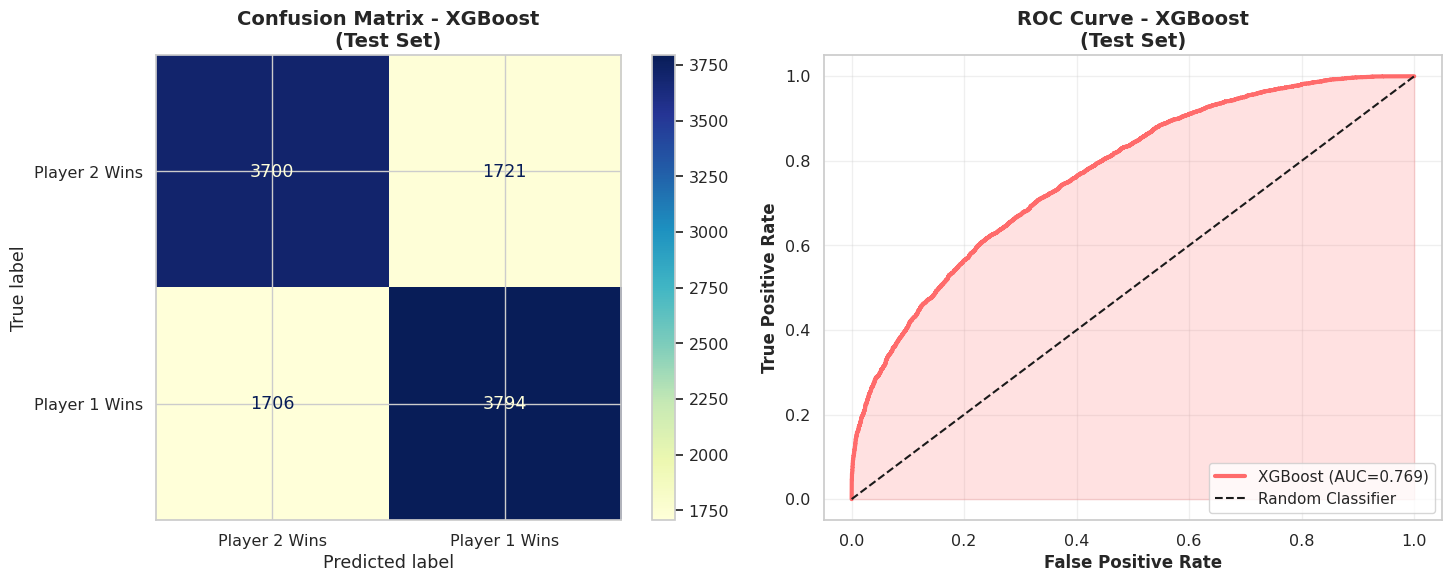


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
                                        RESUMEN FINAL

✅ El modelo **XGBoost** es el GANADOR según nuestro criterio de evaluación.
✅ Logró el mejor CV Score (0.7054) y mantiene buen rendimiento en test.
✅ Este modelo será utilizado para las predicciones finales del proyecto.

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯



In [64]:
# Determinar el mejor modelo global
best_model = df_results.iloc[0]
best_model_name = best_model['Modelo']
best_model_grid = models_dict[best_model_name]
y_pred_best = best_model_grid.best_estimator_.predict(X_test)

# Banner del ganador
print("\n" + "🏆" * 50)
print("=" * 100)
print(" " * 38 + "🎉 MODELO GANADOR 🎉")
print("=" * 100)
print("🏆" * 50 + "\n")

print(f"{'   Modelo:':<25} {best_model_name}")
print(f"{'   Tipo:':<25} {best_model['Tipo']}")
print(f"{'   CV Score:':<25} {best_model['CV Score']:.4f}")
print(f"{'   Test Score:':<25} {best_model['Test Score']:.4f}")
print(f"{'   Diferencia (CV-Test):':<25} {best_model['Diferencia (CV - Test)']:.4f}")
if best_model_name in auc_scores:
    print(f"{'   AUC Score:':<25} {auc_scores[best_model_name]:.4f}")

print("\n" + "=" * 100)

# Justificación de la elección
print("\n📊 JUSTIFICACIÓN DE LA ELECCIÓN:")
print("-" * 100)
print(f"1. **Criterio Principal (CV Score)**: Con un CV Score de {best_model['CV Score']:.4f}, este modelo")
print(f"   obtuvo el mejor rendimiento en validación cruzada, superando a los otros {len(df_results)-1} modelos.")
print(f"\n2. **Generalización (Test Score)**: El Test Score de {best_model['Test Score']:.4f} confirma que")
print(f"   el modelo generaliza bien a datos no vistos.")
print(f"\n3. **Overfitting**: Con una diferencia de {best_model['Diferencia (CV - Test)']:.4f} entre CV y Test,")
if best_model['Diferencia (CV - Test)'] < 0.02:
    print(f"   el modelo muestra **NO hay signos significativos de overfitting**.")
else:
    print(f"   el modelo muestra **cierto overfitting**, pero sigue siendo el mejor en validación cruzada.")

# Comparación con segundo lugar
second_best = df_results.iloc[1]
diff_from_second = best_model['CV Score'] - second_best['CV Score']
print(f"\n4. **Ventaja sobre el segundo puesto**: Supera a '{second_best['Modelo']}' por")
print(f"   {diff_from_second:.4f} puntos ({diff_from_second*100:.2f}%) en CV Score.")

print("\n" + "=" * 100)

# Evaluación completa del ganador
print(f"\n📈 EVALUACIÓN COMPLETA - {best_model_name} (Test Set)")
print("=" * 100 + "\n")
print(classification_report(y_test, y_pred_best, target_names=['Player 2 Wins', 'Player 1 Wins']))

# Matriz de confusión del ganador
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, cmap='YlGnBu', ax=axes[0],
                                        display_labels=['Player 2 Wins', 'Player 1 Wins'], values_format='d')
axes[0].set_title(f'Confusion Matrix - {best_model_name}\n(Test Set)', 
                 fontsize=14, fontweight='bold')

# Curva ROC del ganador destacada
if best_model_name in auc_scores:
    try:
        if hasattr(best_model_grid.best_estimator_.named_steps['clf'], 'predict_proba'):
            y_proba_best = best_model_grid.best_estimator_.predict_proba(X_test)[:, 1]
        elif hasattr(best_model_grid.best_estimator_.named_steps['clf'], 'decision_function'):
            y_proba_best = best_model_grid.best_estimator_.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_proba_best)
        auc_best = auc_scores[best_model_name]
        
        axes[1].plot(fpr, tpr, linewidth=3, label=f'{best_model_name} (AUC={auc_best:.3f})', color='#FF6B6B')
        axes[1].fill_between(fpr, tpr, alpha=0.2, color='#FF6B6B')
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)
        axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        axes[1].set_title(f'ROC Curve - {best_model_name}\n(Test Set)', fontsize=14, fontweight='bold')
        axes[1].legend(loc='lower right', fontsize=11)
        axes[1].grid(alpha=0.3)
    except:
        axes[1].text(0.5, 0.5, 'ROC Curve not available', ha='center', va='center', fontsize=12)
        axes[1].set_xlim([0, 1])
        axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Resumen final
print("\n" + "🎯" * 50)
print("=" * 100)
print(" " * 40 + "RESUMEN FINAL")
print("=" * 100)
print(f"\n✅ El modelo **{best_model_name}** es el GANADOR según nuestro criterio de evaluación.")
print(f"✅ Logró el mejor CV Score ({best_model['CV Score']:.4f}) y mantiene buen rendimiento en test.")
print(f"✅ Este modelo será utilizado para las predicciones finales del proyecto.")
print("\n" + "=" * 100)
print("🎯" * 50 + "\n")

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 4-Conclusiones 

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Tiempo total de ejecución

In [65]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 1:20:05.403402
